In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import logging
logging.basicConfig(level=logging.INFO)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


## Sorted Spikes

In [526]:
from replay_trajectory_classification import SortedSpikesClassifier
from dask.diagnostics import ProgressBar 

position = data['position_info'].loc[:, ['x_position', 'y_position']]
is_training = data['position_info'].speed > 4

with ProgressBar():
    classifier = SortedSpikesClassifier(continuous_transition_types=['random_walk_with_absorbing_boundaries',
                                        'uniform', 'identity'],
                                         place_bin_size=1.5,
                                         movement_std=0.05).fit(
        position, data['spikes'], is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


[########################################] | 100% Completed | 14min 11.7s


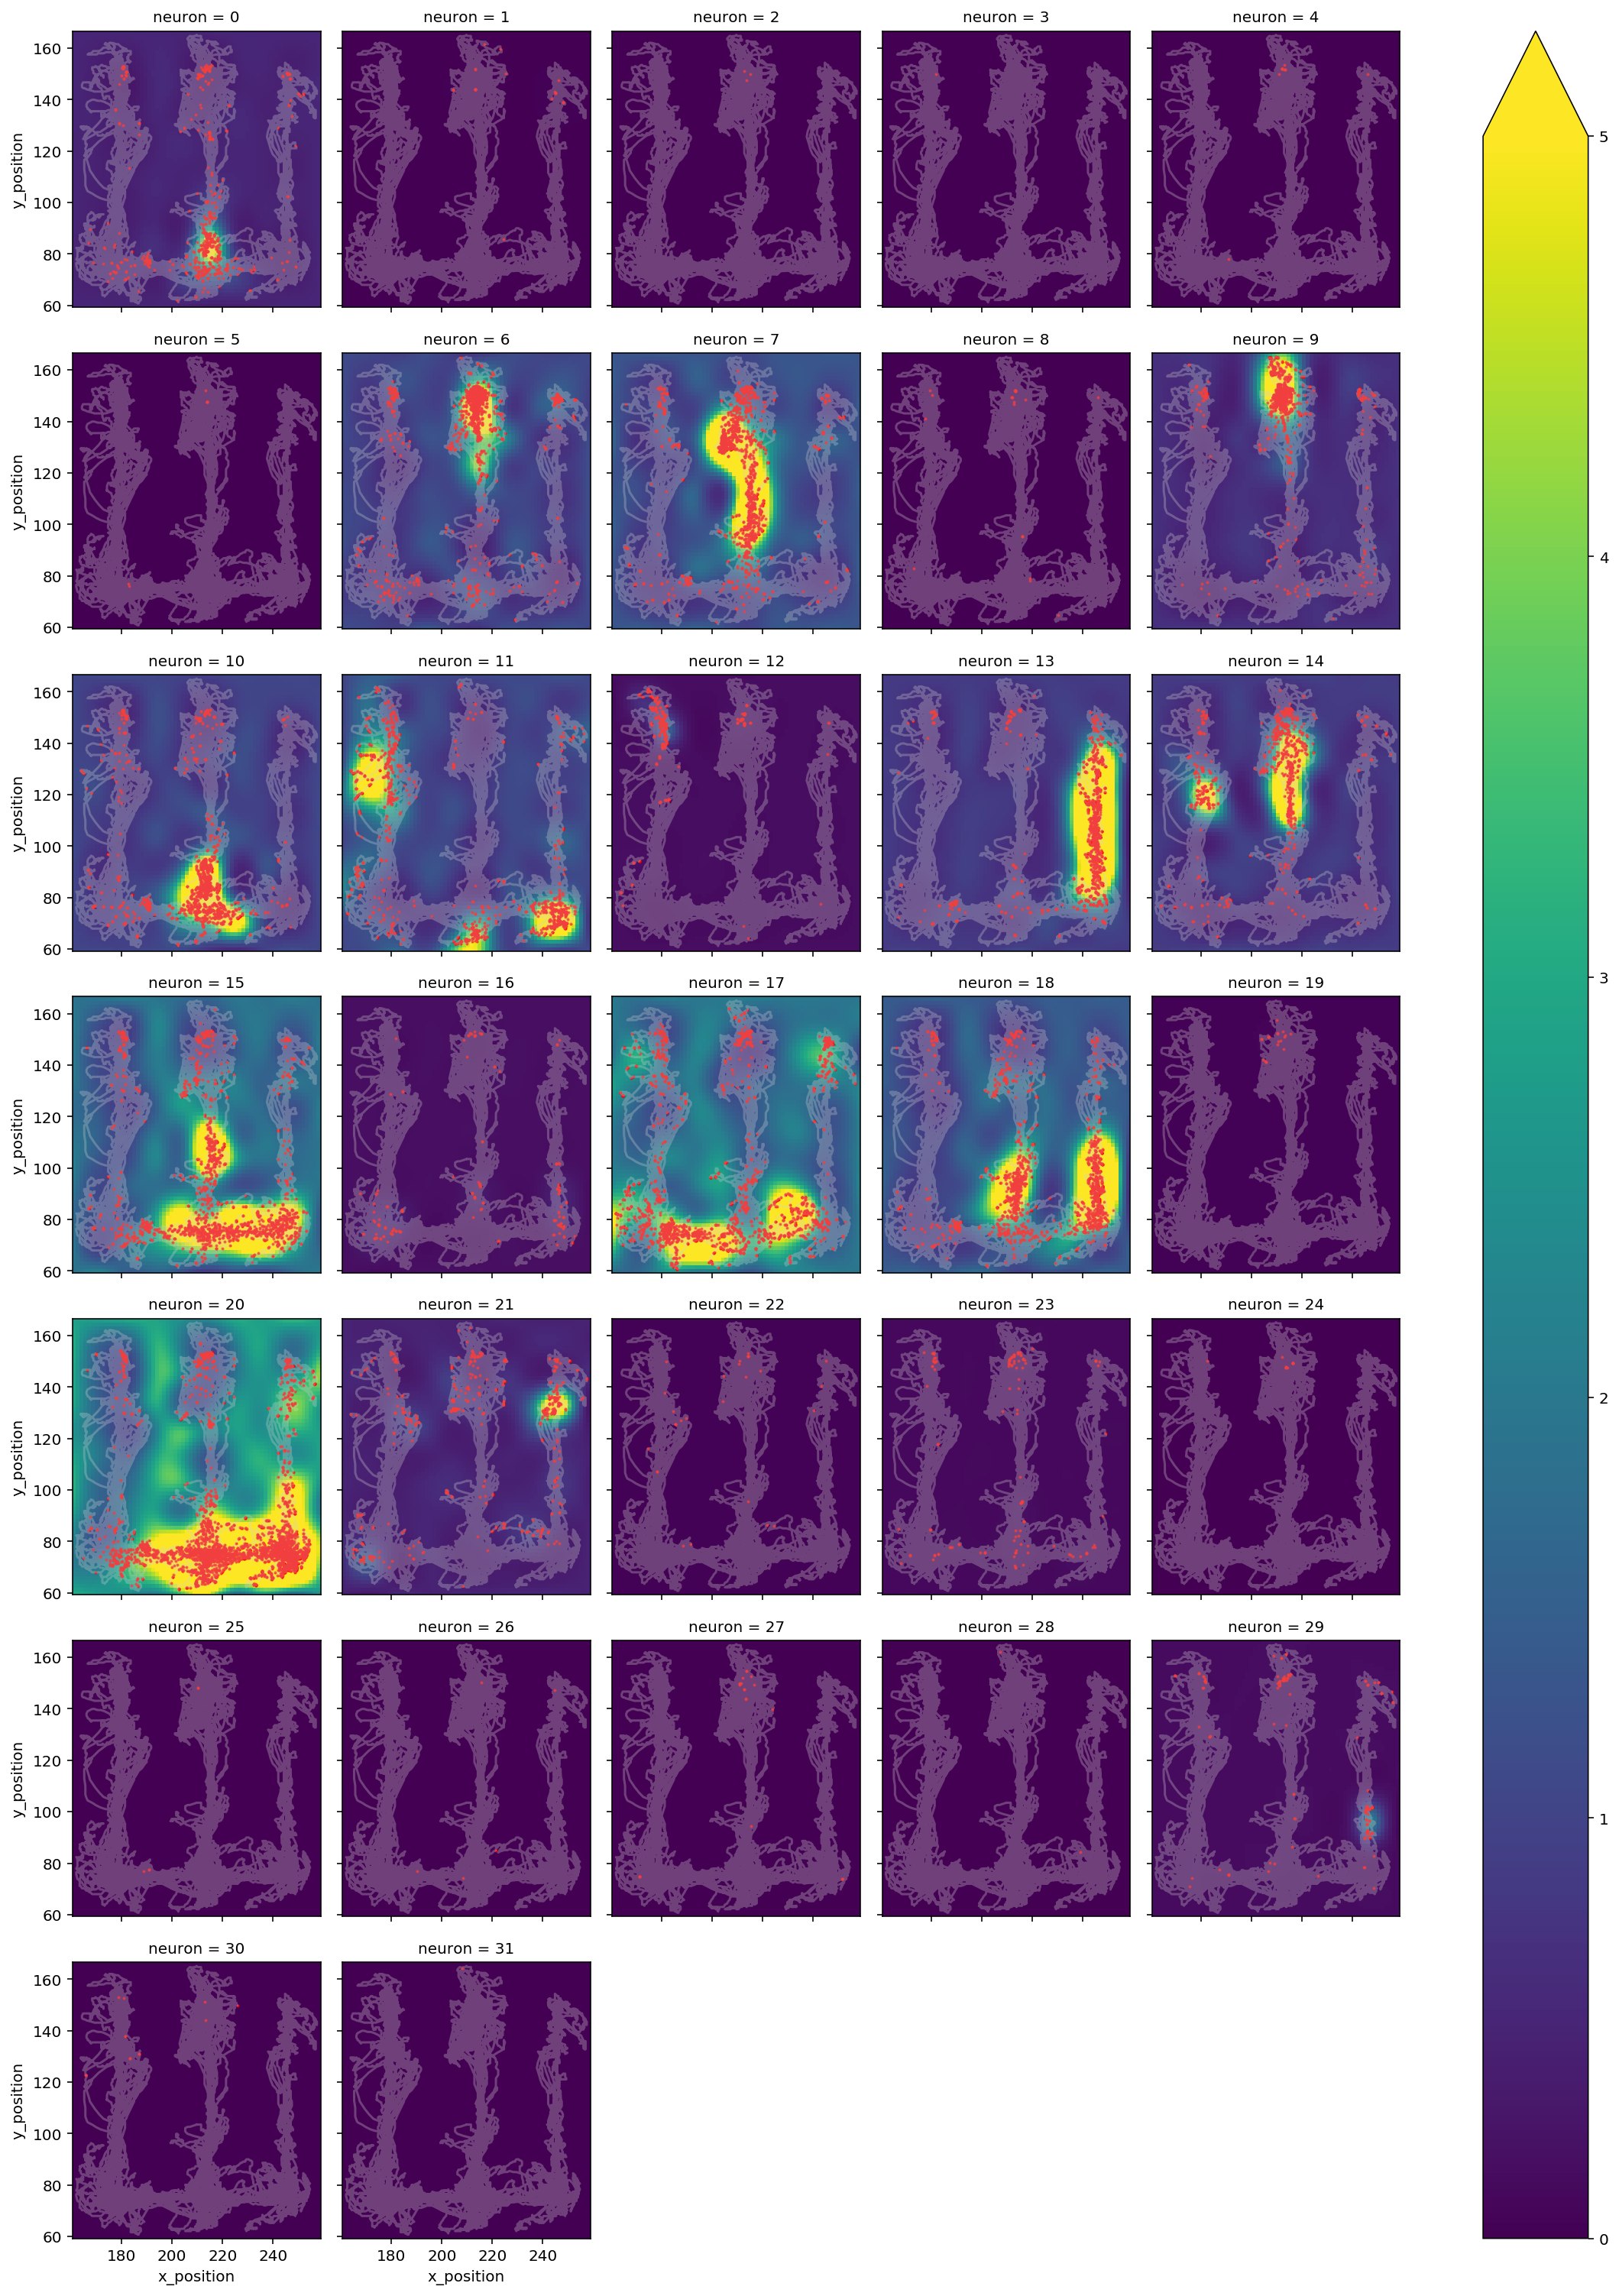

In [527]:
from replay_trajectory_classification.load_example_data import SAMPLING_FREQUENCY

g = (classifier.place_fields_.unstack() * SAMPLING_FREQUENCY).plot(
    x='x_position', y='y_position', col='neuron', col_wrap=5, vmin=0.0, vmax=5.0)

for ax, is_spike in zip(g.axes.flat, data['spikes'].values.T):
    ax.plot(position.iloc[:, 0], position.iloc[:, 1], color='lightgrey', alpha=0.3)
    ax.scatter(position.values[is_spike > 0, 0], position.values[is_spike > 0, 1],
               color='red', s=1, alpha=0.7)

In [ ]:
from loren_frank_data_processing import reshape_to_segments

ripple_spikes = reshape_to_segments(
    data['spikes'], data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=SAMPLING_FREQUENCY)

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=SAMPLING_FREQUENCY)

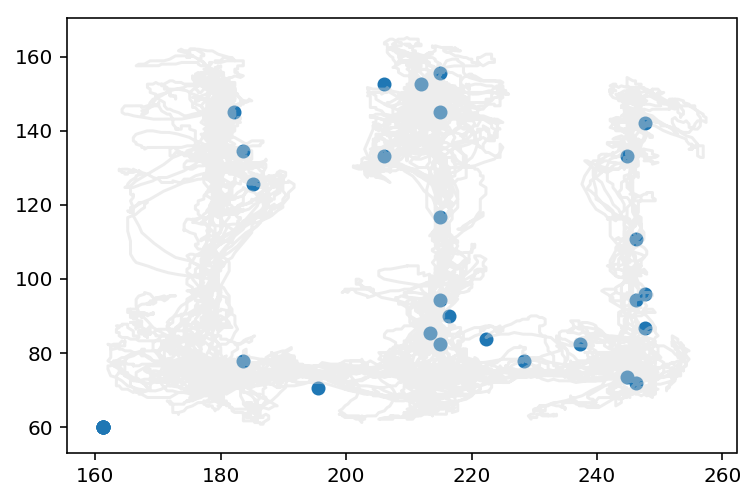

In [528]:
place_field_max = np.asarray(
    classifier.place_fields_.position[classifier.place_fields_.argmax('position')].values.tolist())

plt.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4)
plt.scatter(place_field_max[:, 0], place_field_max[:, 1])

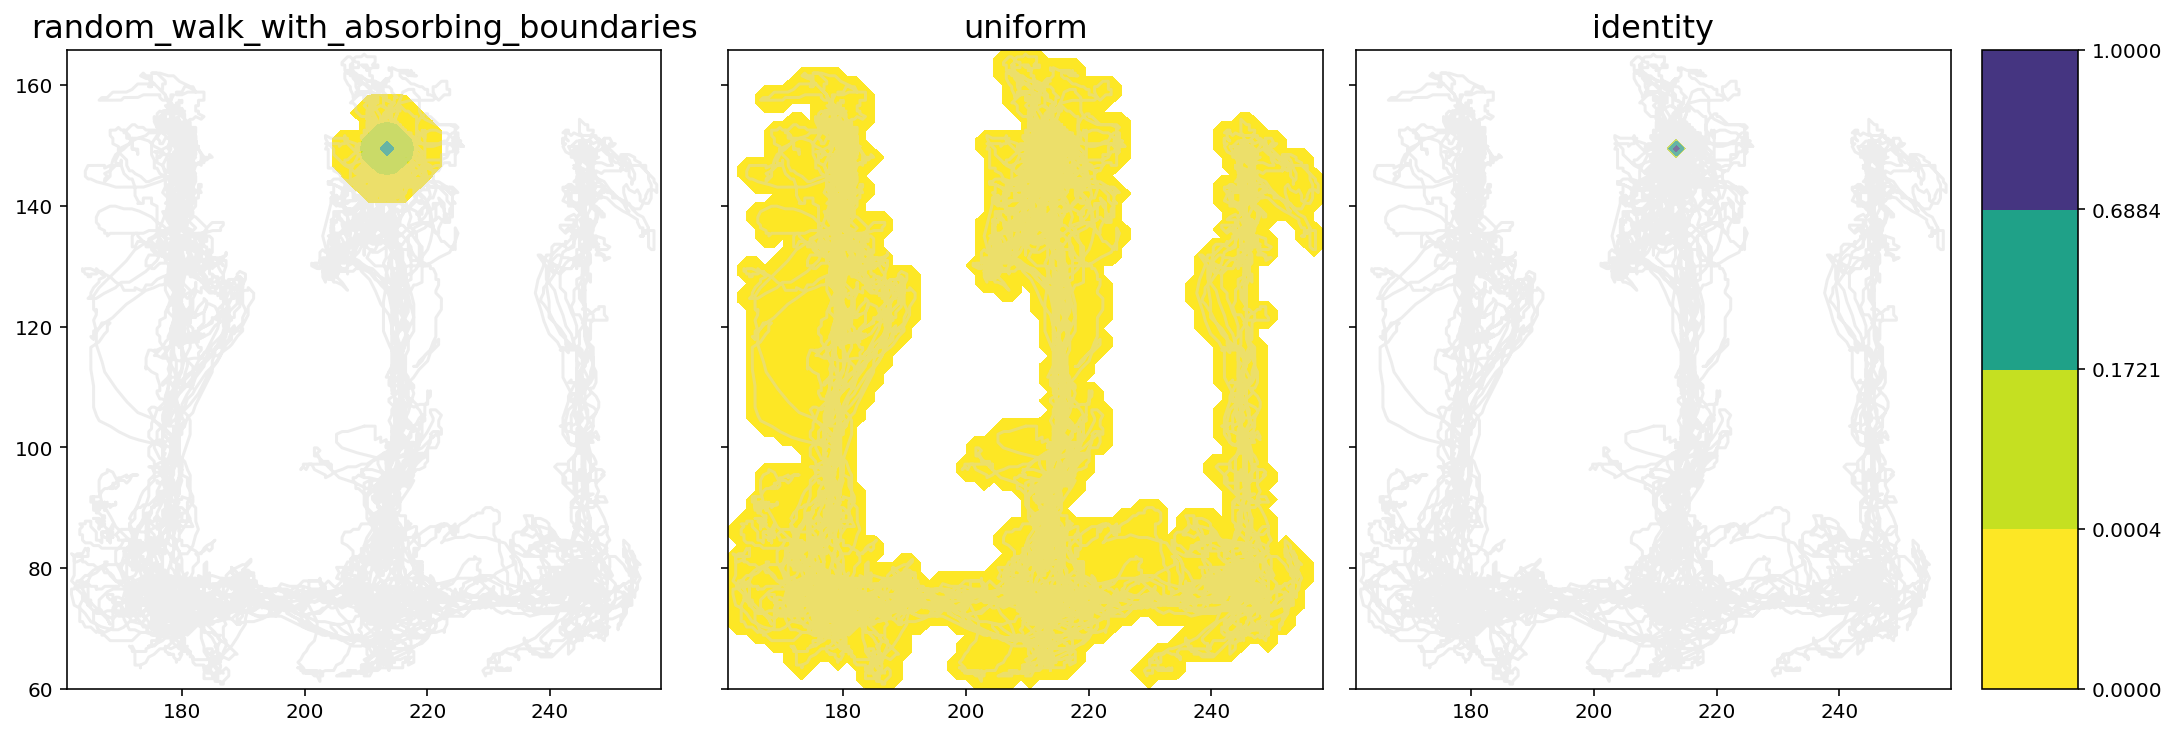

In [710]:
centers = [edge[:-1] + (np.diff(edge)[0] / 2) for edge in classifier.edges_]
x, y = np.meshgrid(centers[0], centers[1])
ind = np.nonzero(classifier.continuous_state_transition_[0].sum(axis=1))[0][-204]
levels = np.asarray([st.max() for st in classifier.continuous_state_transition_])
levels = np.append(levels, np.spacing(1))
levels = np.append(levels, classifier.continuous_state_transition_[0].max() / 4)
levels = np.sort(levels)
cmap = 'viridis_r'

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)

for ax, st, name in zip(axes.flat, classifier.continuous_state_transition_, classifier.continuous_transition_types):
    ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=0)
    g = ax.contourf(x, y, st[ind, :].reshape(classifier.centers_shape_),
                    cmap=cmap, vmin=np.spacing(1), vmax=levels.max(),
                    levels=levels, zorder=0, alpha=1)
    ax.set_title(name, fontsize=16)
    
plt.colorbar(g, ax=ax);

In [530]:
ripple_number = 219

result = classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)

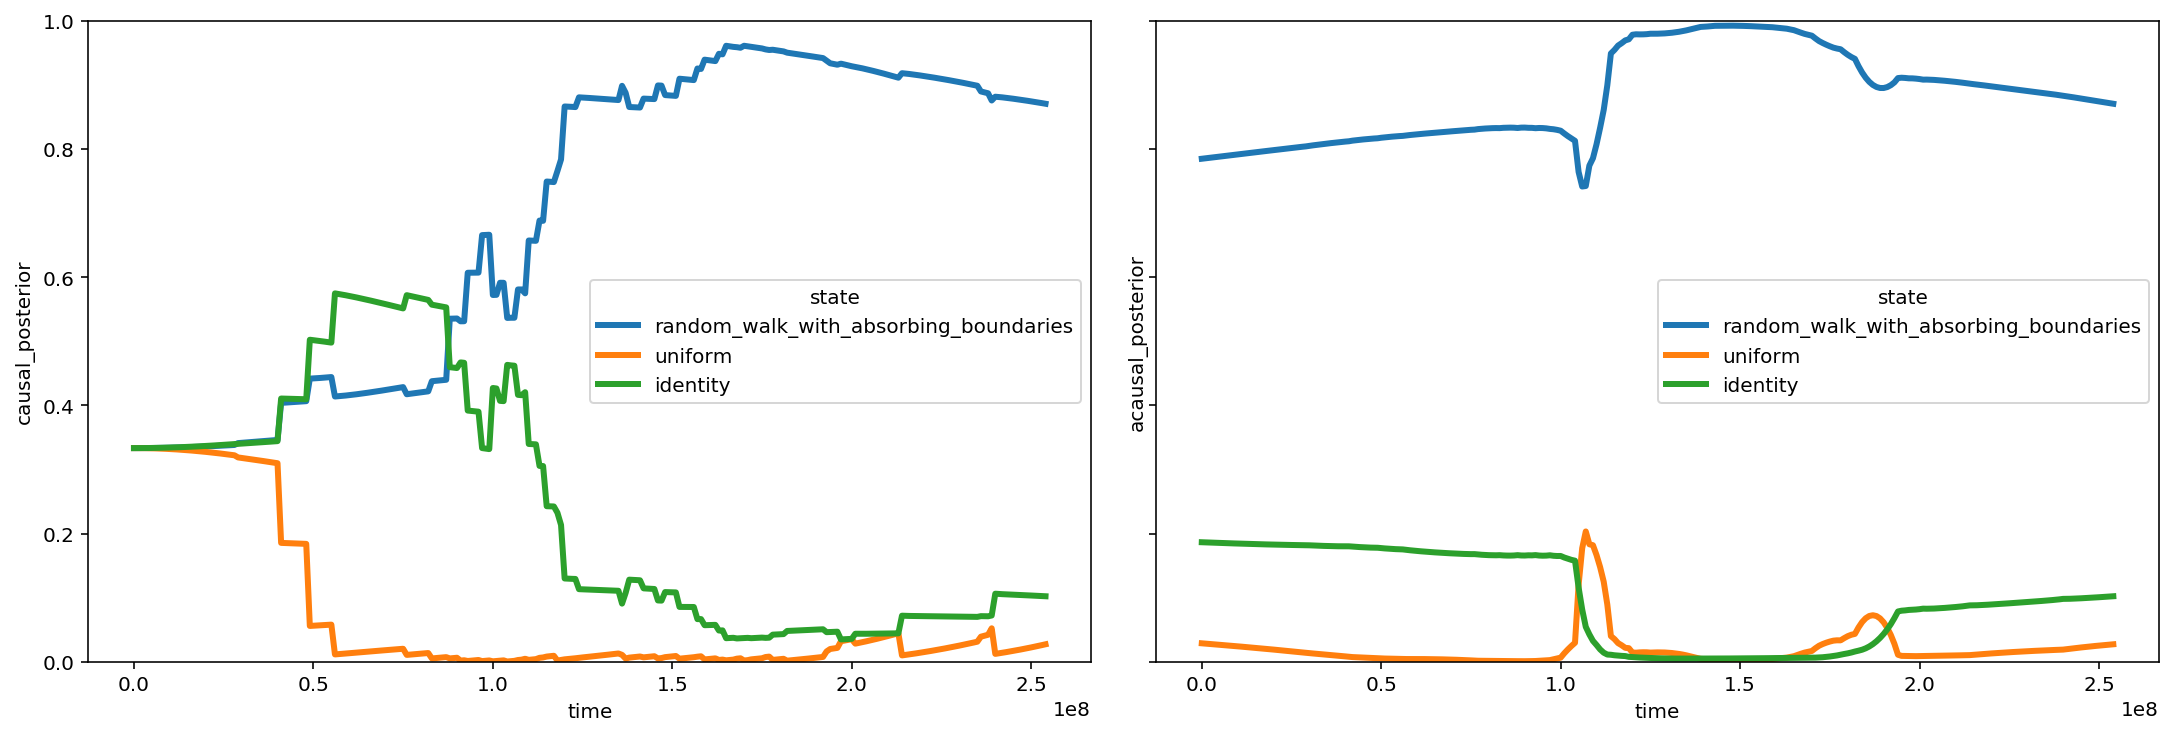

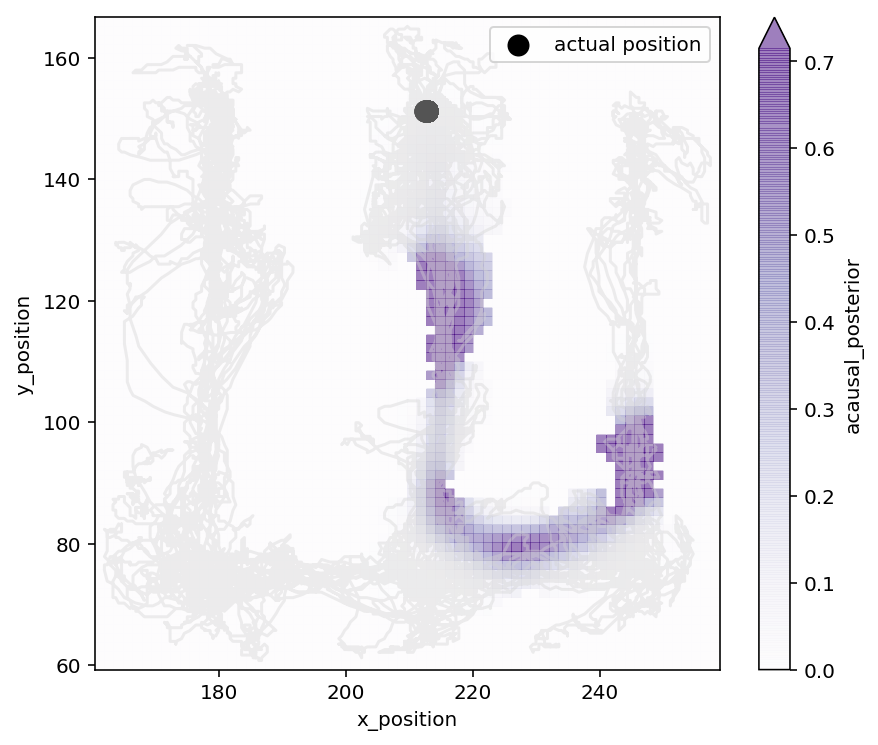

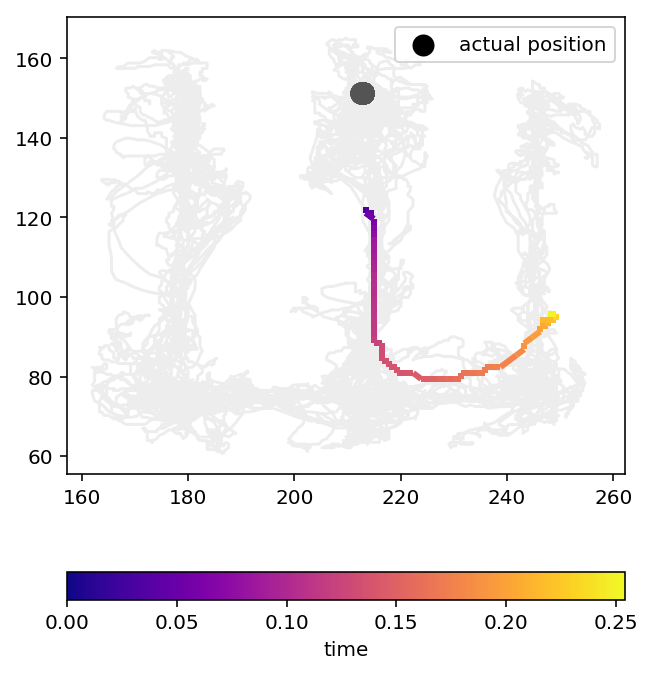

In [536]:
from replay_trajectory_classification.visualization import (
    maximum_a_posteriori_estimate, plot_2D_position_with_color_time)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples',
    alpha=0.5, vmin=0.0)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend();

In [712]:
from tqdm.auto import tqdm

results = [classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)
           for ripple_number in tqdm(data['ripple_times'].loc[data['ripple_times'].n_unique_spiking > 4].index)]

In [714]:
probabilties = [classifier.predict_proba(r).acausal_posterior for r in results]
duration = [(p > 0.8).sum('time') / SAMPLING_FREQUENCY for p in probabilties]

dim = data['ripple_times'].loc[data['ripple_times'].n_unique_spiking > 4].index
duration = xr.concat(duration, dim=dim).to_dataframe().unstack(level=1)
to_name = {'identity': 'hover_duration',
           'uniform': 'fragmented_duration',
           'random_walk_with_absorbing_boundaries': 'continuous_duration'}
duration.columns = list(duration.columns.get_level_values('state'))
duration = duration.rename(columns=to_name)
duration = pd.concat((duration, (duration > 0.0).rename(columns=lambda c: c.split('_')[0])), axis=1)

In [717]:
duration.to_csv('duration-1-5.csv')

In [ ]:
# import xarray as xr
# from loren_frank_data_processing import save_xarray

# results = xr.concat(results, dim=data['ripple_times'].index)
# save_xarray(pwd, epoch_key, results)

In [726]:
is_classified = np.any(duration.iloc[:, 3:] > 0, axis=1)
is_classified.sum()

38

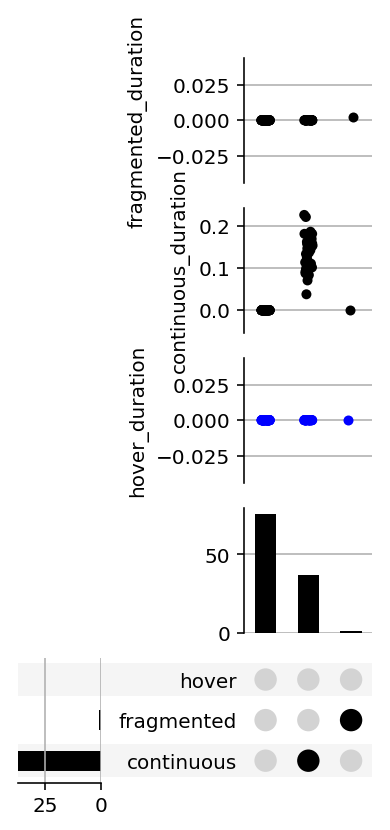

In [720]:
from upsetplot import UpSet
upset = UpSet(duration.set_index(['hover', 'continuous', 'fragmented']),
              sum_over=False, intersection_plot_elements=3)
upset.add_catplot(value='hover_duration', kind='strip', color='blue')
upset.add_catplot(value='continuous_duration', kind='strip', color='black')
upset.add_catplot(value='fragmented_duration', kind='strip', color='black')
upset.plot();

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x1c719f2390>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x1d2b780208>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x1c5d359080>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x1d23bded68>}

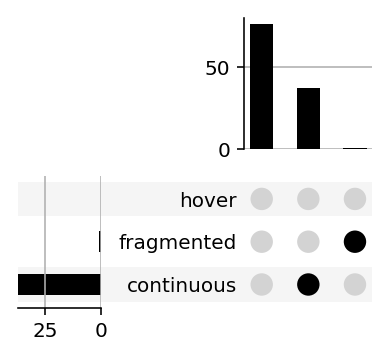

In [721]:
upset = UpSet(duration.set_index(['hover', 'continuous', 'fragmented']),
              sum_over=False, intersection_plot_elements=3)
upset.plot()

In [722]:
duration.loc[duration.iloc[:, 3:5].sum(axis=1) > 1]

Empty DataFrame
Columns: [hover_duration, continuous_duration, fragmented_duration, hover, continuous, fragmented]
Index: []

In [723]:
ripple_number = 284
result = results[ripple_number - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

IndexError: list index out of range

In [140]:
duration.index[duration.loc[:, 'hover']]

Int64Index([  1,   6,   8,  33,  38, 100, 101, 106, 110, 118, 123, 133, 146,
            152, 153, 158, 160, 177, 183, 184, 187, 201, 204, 205, 212, 216,
            220, 223, 233, 246, 263, 265, 272, 275, 279, 284, 299, 311, 313,
            314, 320, 329, 338],
           dtype='int64', name='replay_number')

In [176]:
n_spikes = ripple_spikes.sum(axis=1).unstack(level=1).sum(axis=1)
n_unique_spiking = (ripple_spikes.groupby('ripple_number').sum() > 0).sum(axis=1)
n_unique_spiking.loc[duration.loc[:, 'hover']]


replay_number
1       1
6       1
8       2
33      2
38      5
100     3
101     4
106     4
110     2
118     1
123     1
133     2
146     5
152     3
153     4
158     6
160     3
177     2
183     3
184     4
187     6
201     6
204     1
205     2
212     2
216     3
220     2
223     3
233     5
246     3
263     4
265     4
272     3
275     2
279     3
284    10
299     3
311     4
313     3
314     2
320     2
329     1
338     2
dtype: int64

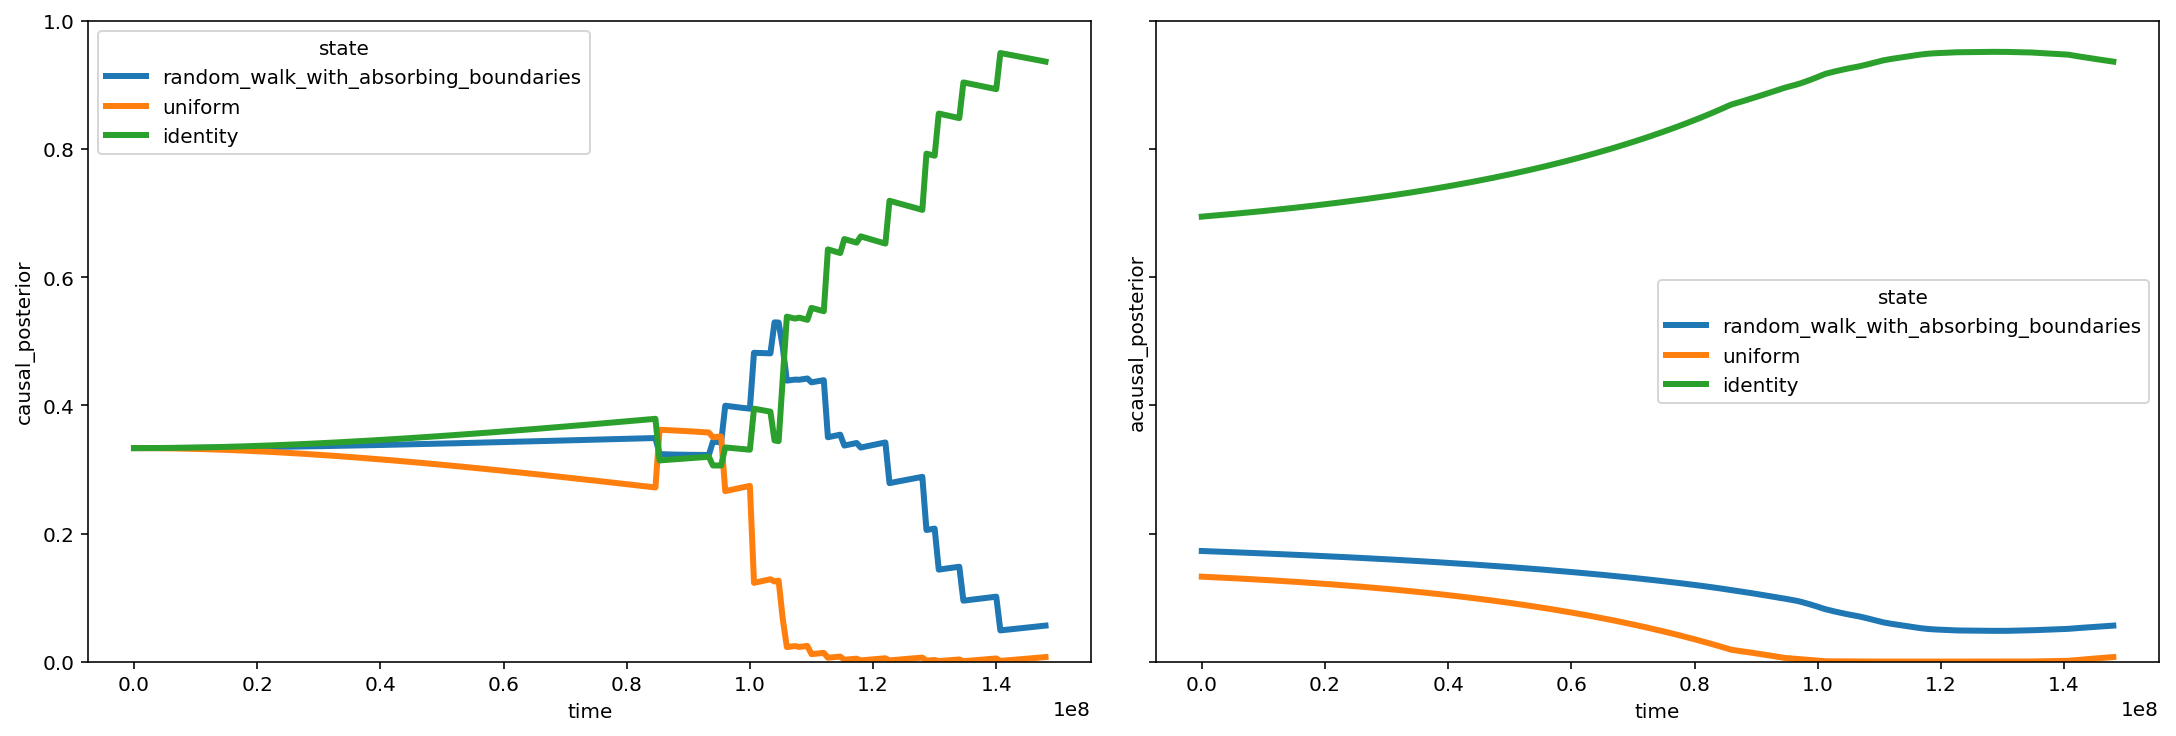

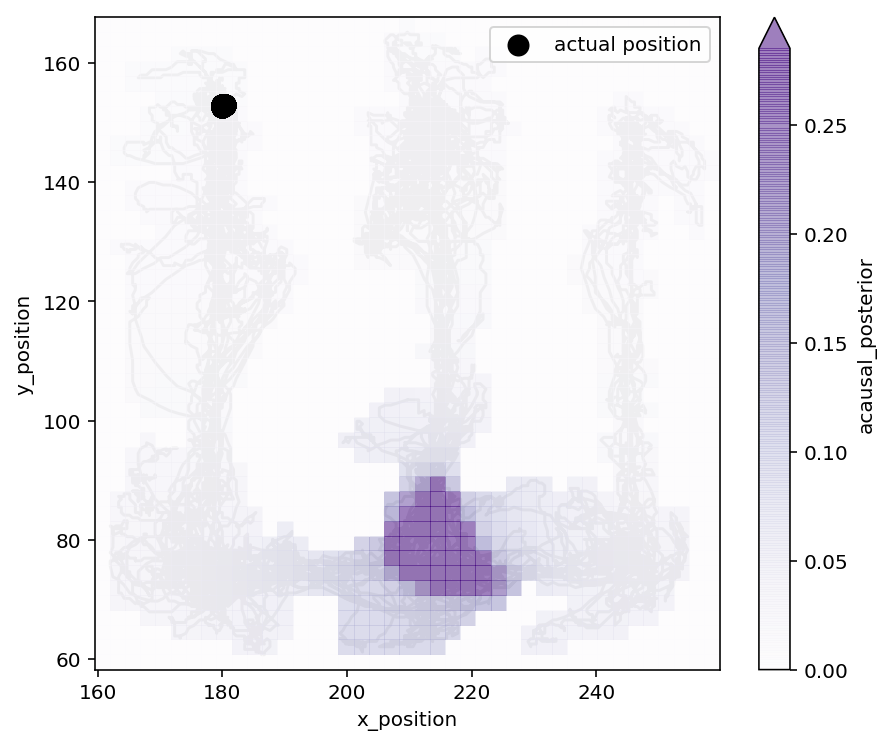

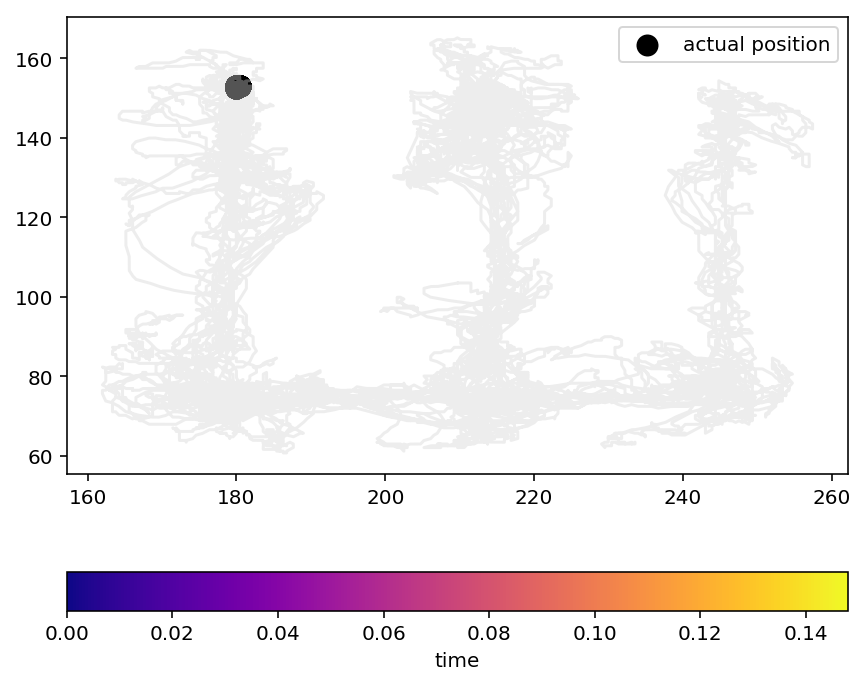

In [179]:
ripple_number = 187
result = results[ripple_number - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

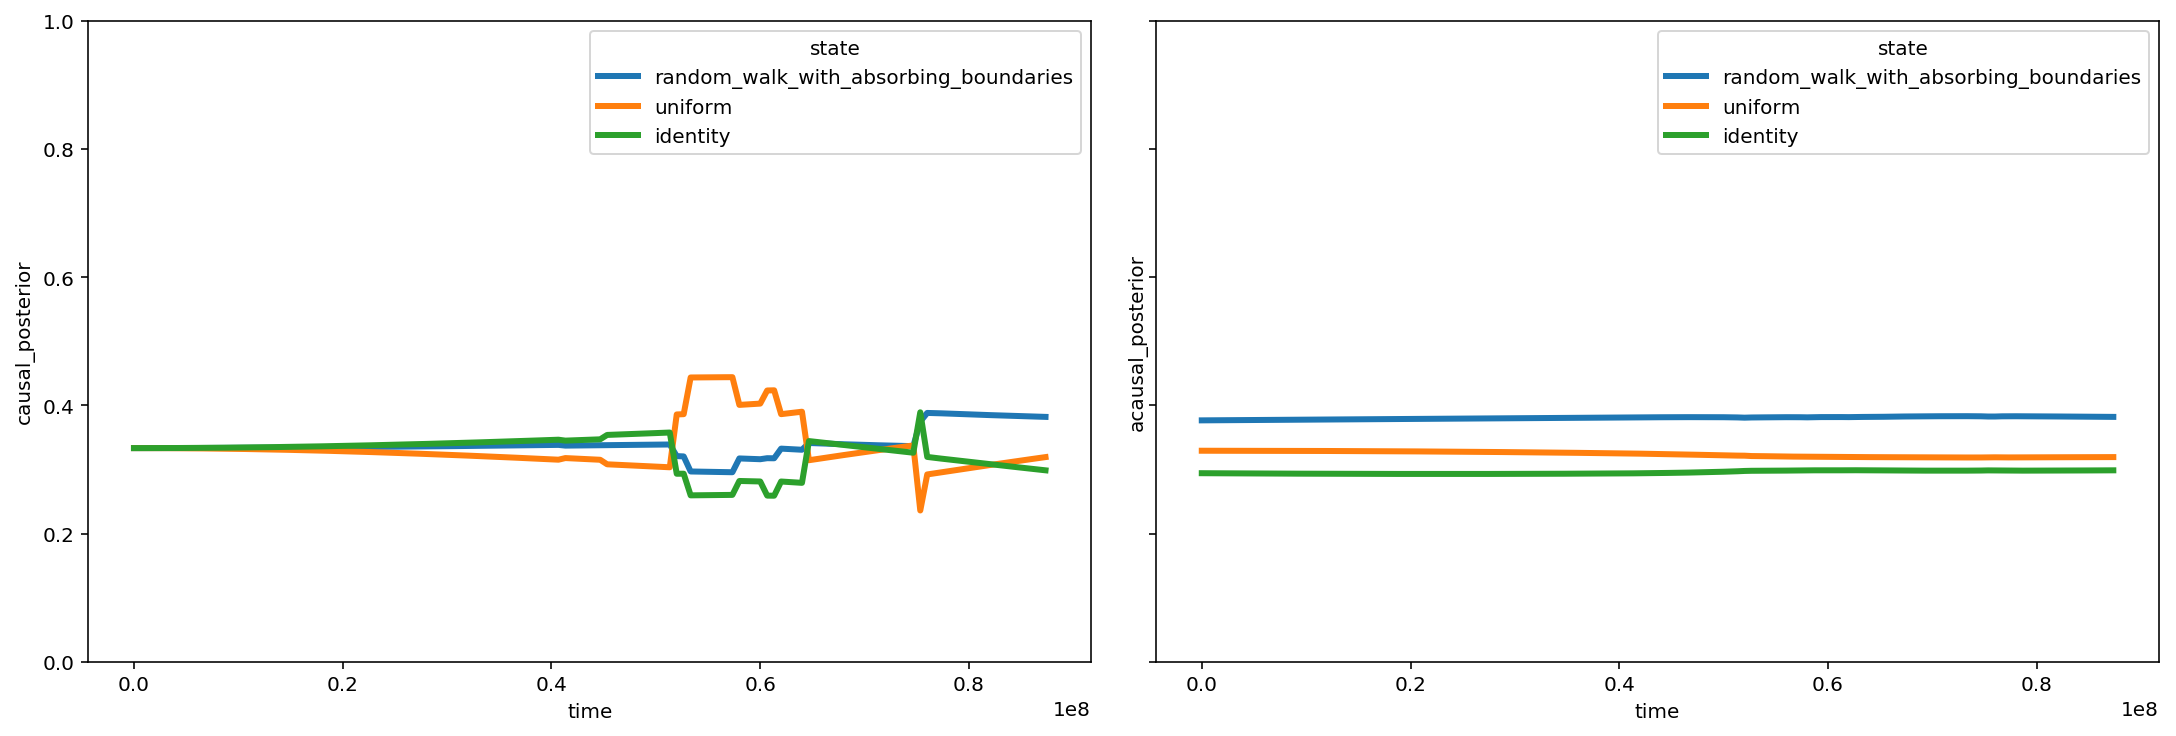

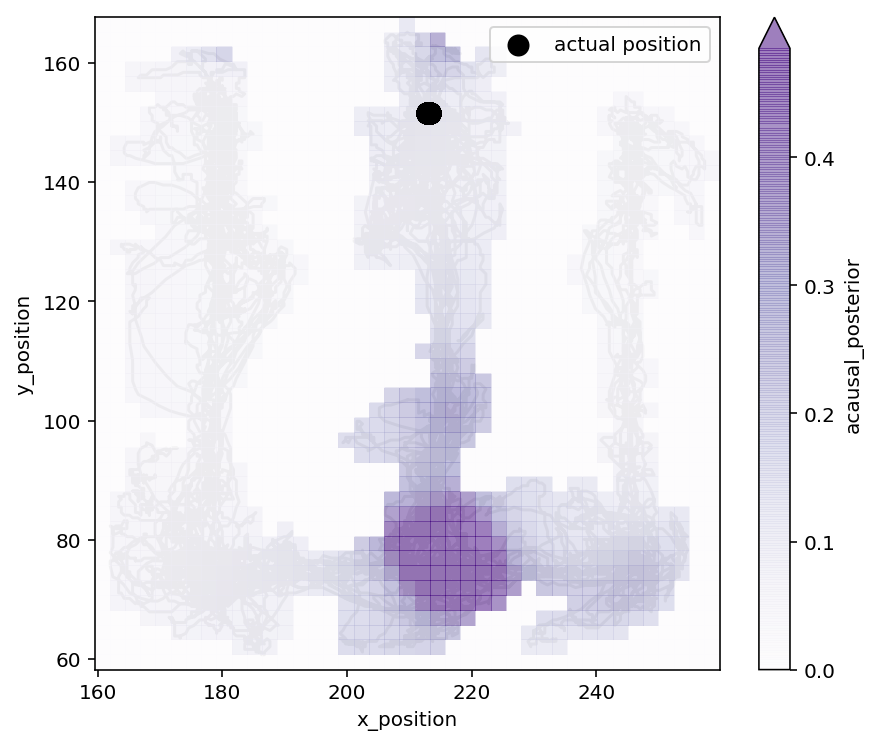

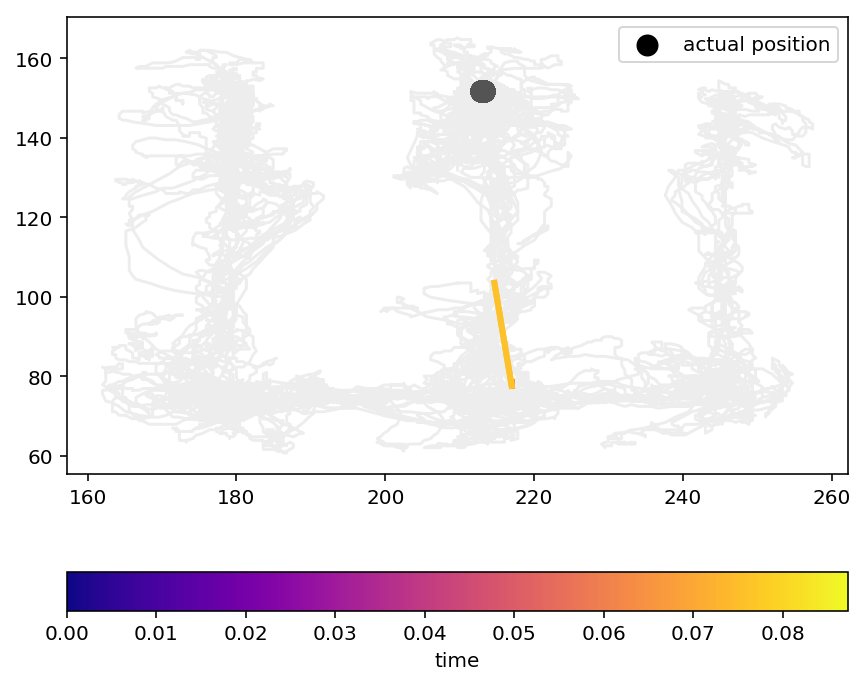

In [226]:
ripple_number = 29
result = results[ripple_number - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.5)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.5, zorder=0)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()


map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
plot_2D_position_with_color_time(
    ripple_spikes.loc[ripple_number].index.total_seconds().values, map_estimate, ax=ax)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black',
           s=100, label='actual position');
ax.legend()

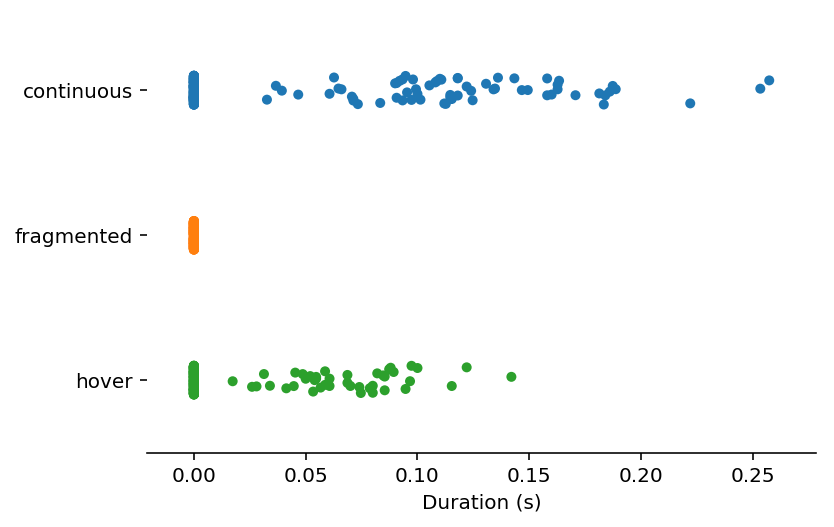

In [195]:
sns.stripplot(data=duration.iloc[:, :3].rename(columns=lambda c: c.split('_')[0]),
              order=['continuous', 'fragmented', 'hover'],
              orient='horizontal')
plt.xlabel('Duration (s)')
sns.despine(left=True)

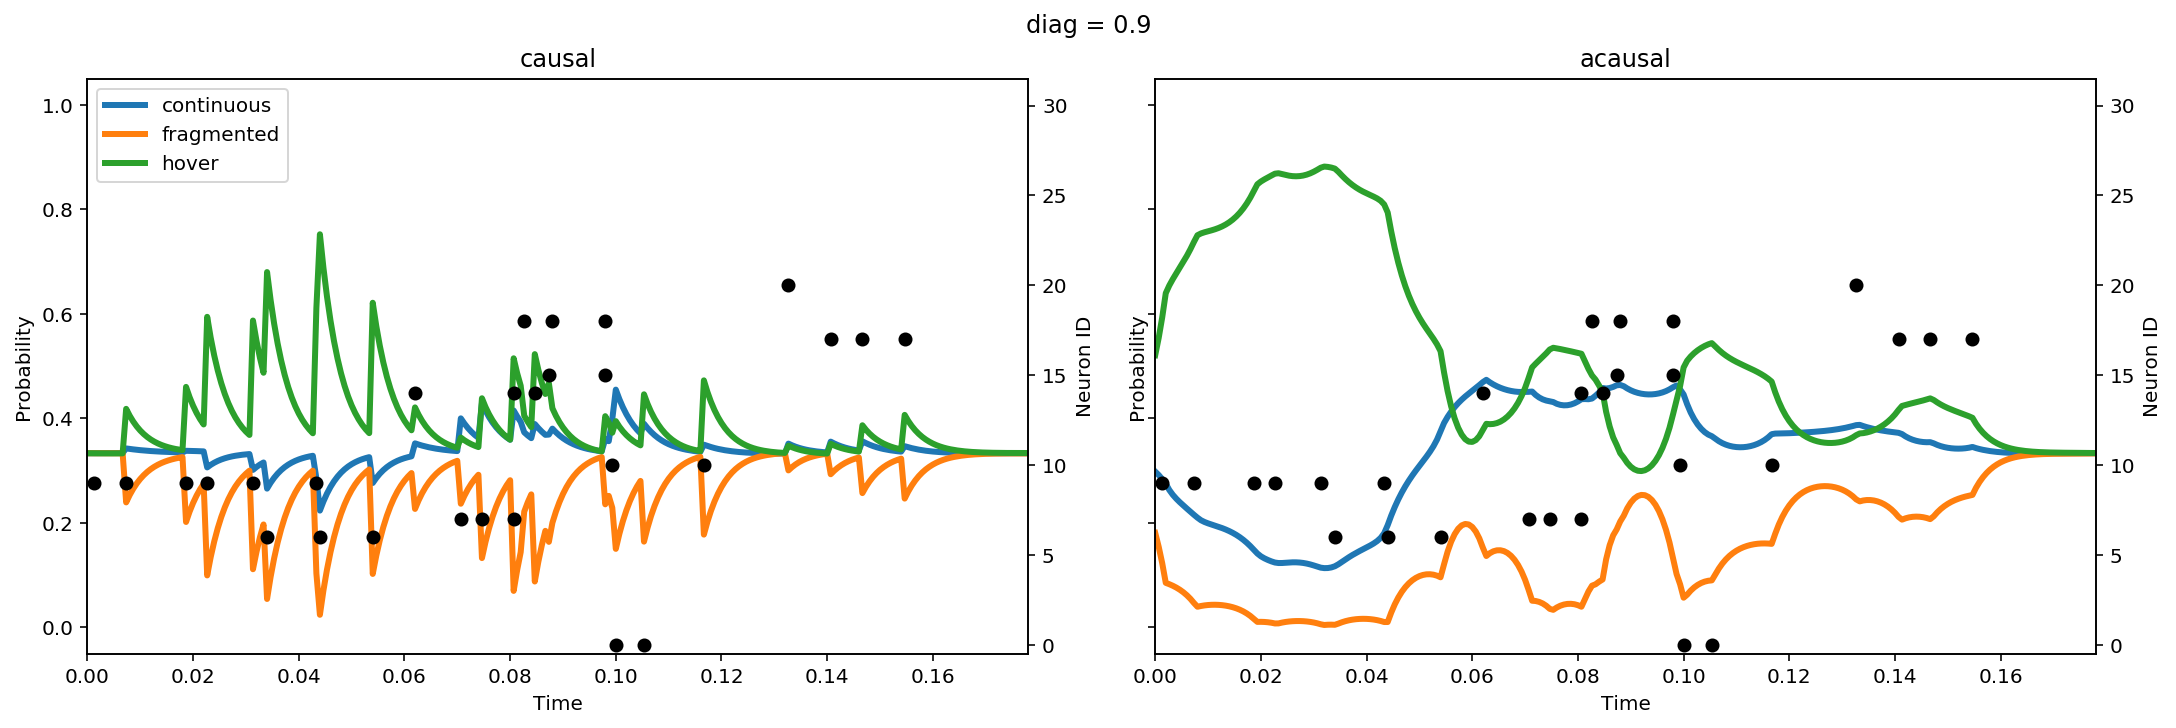

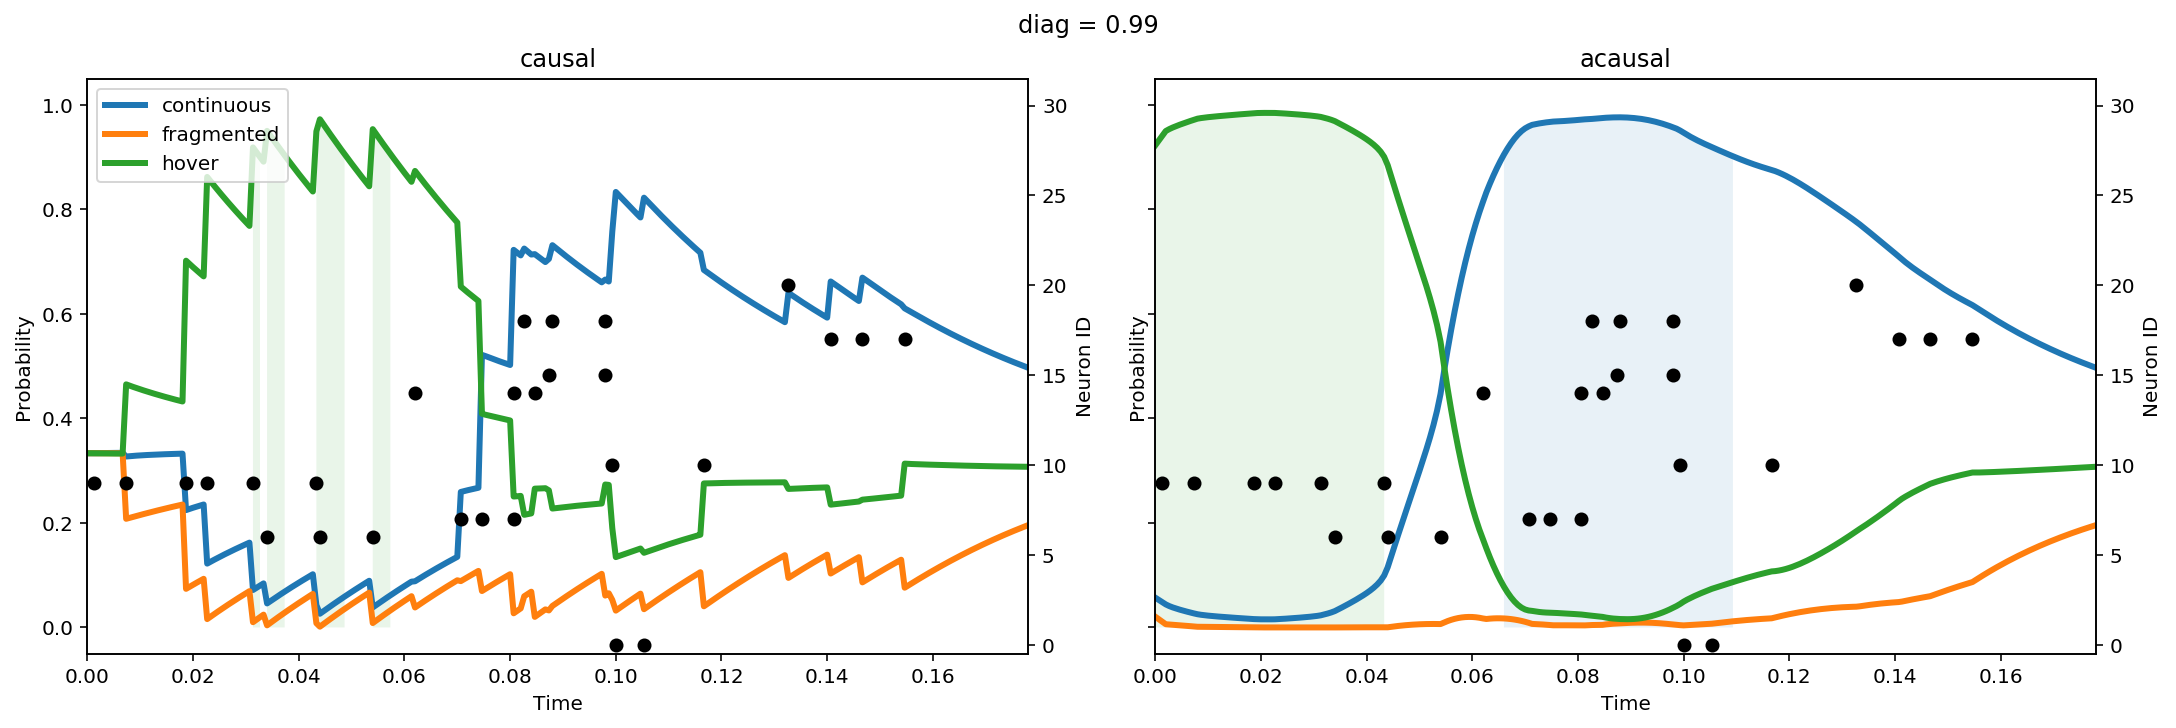

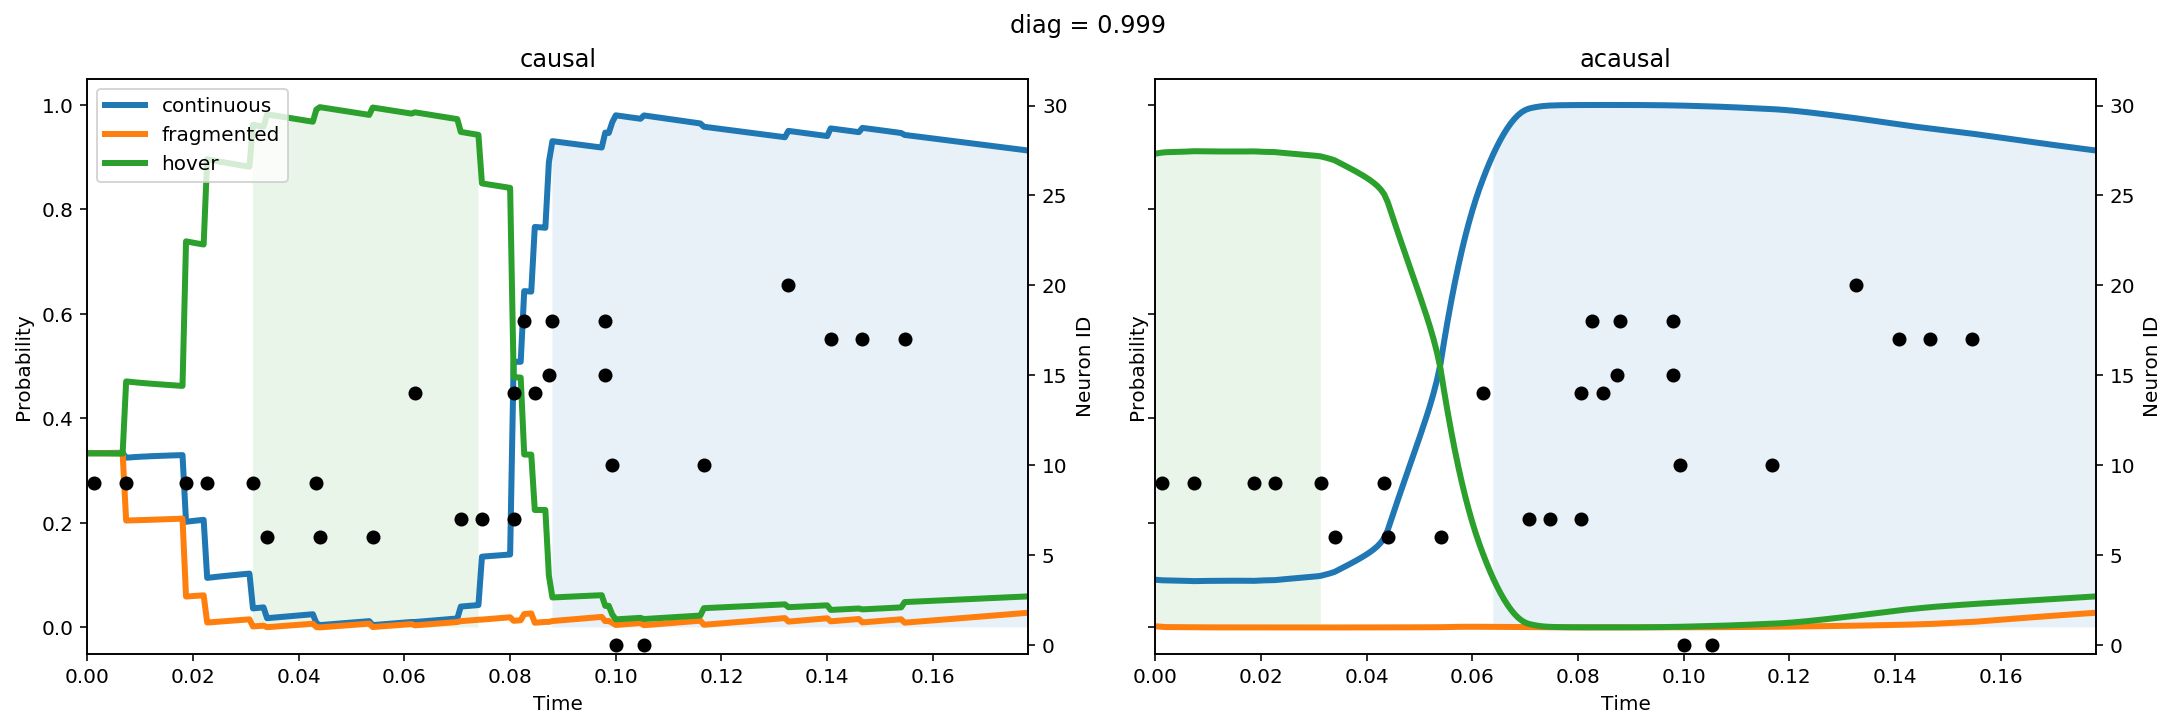

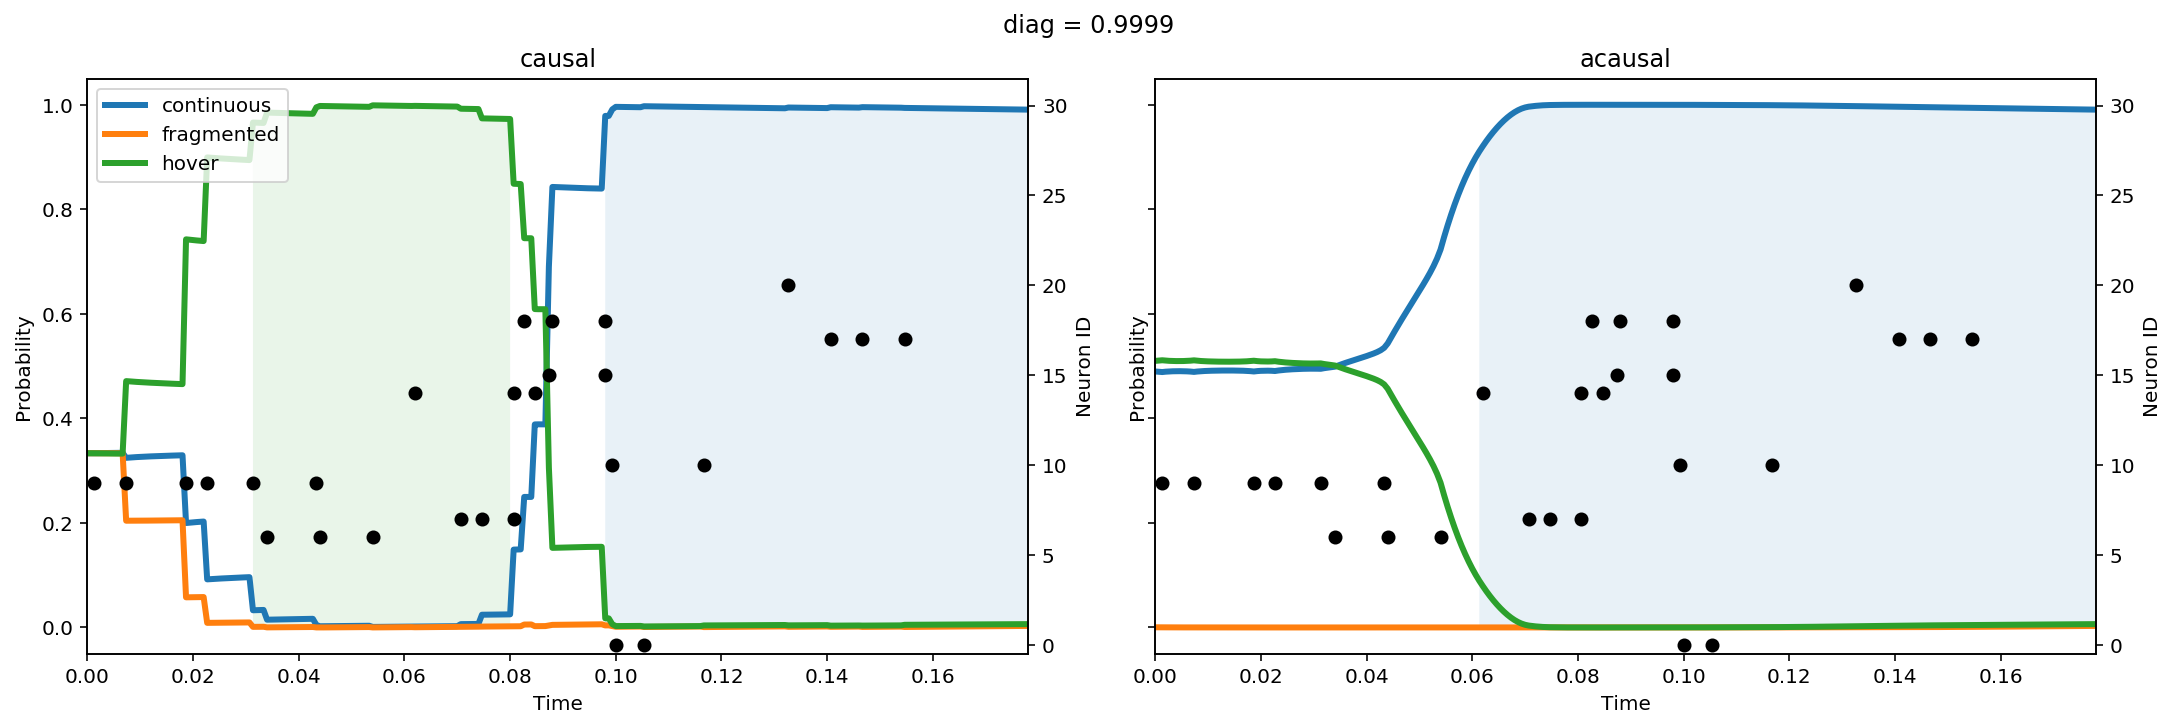

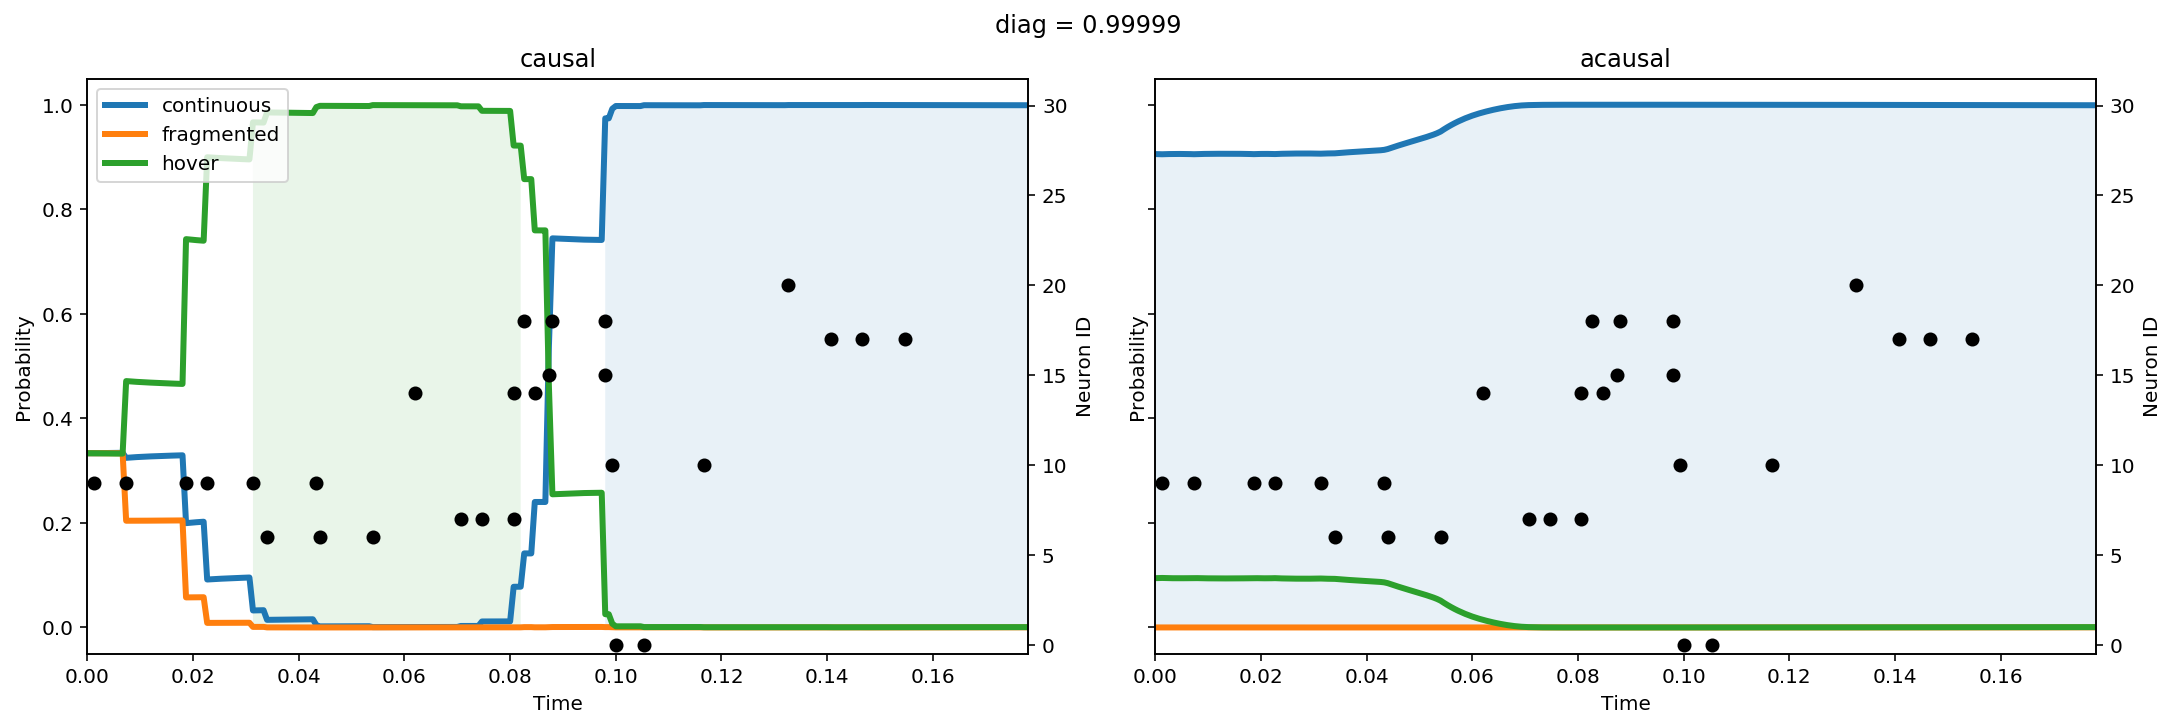

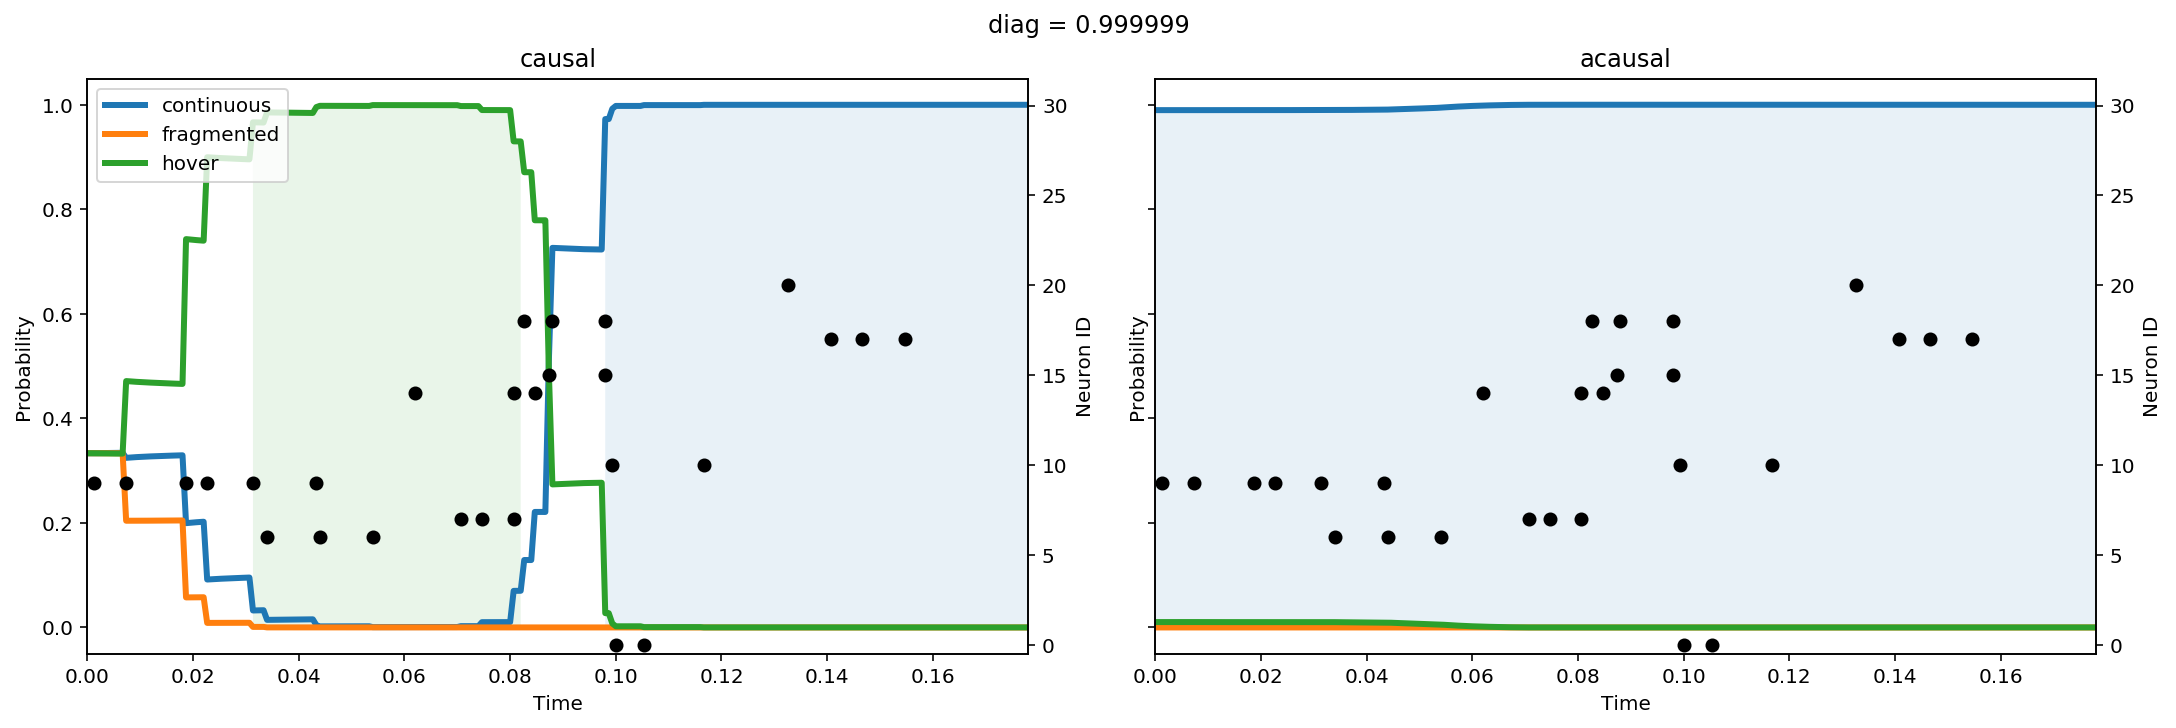

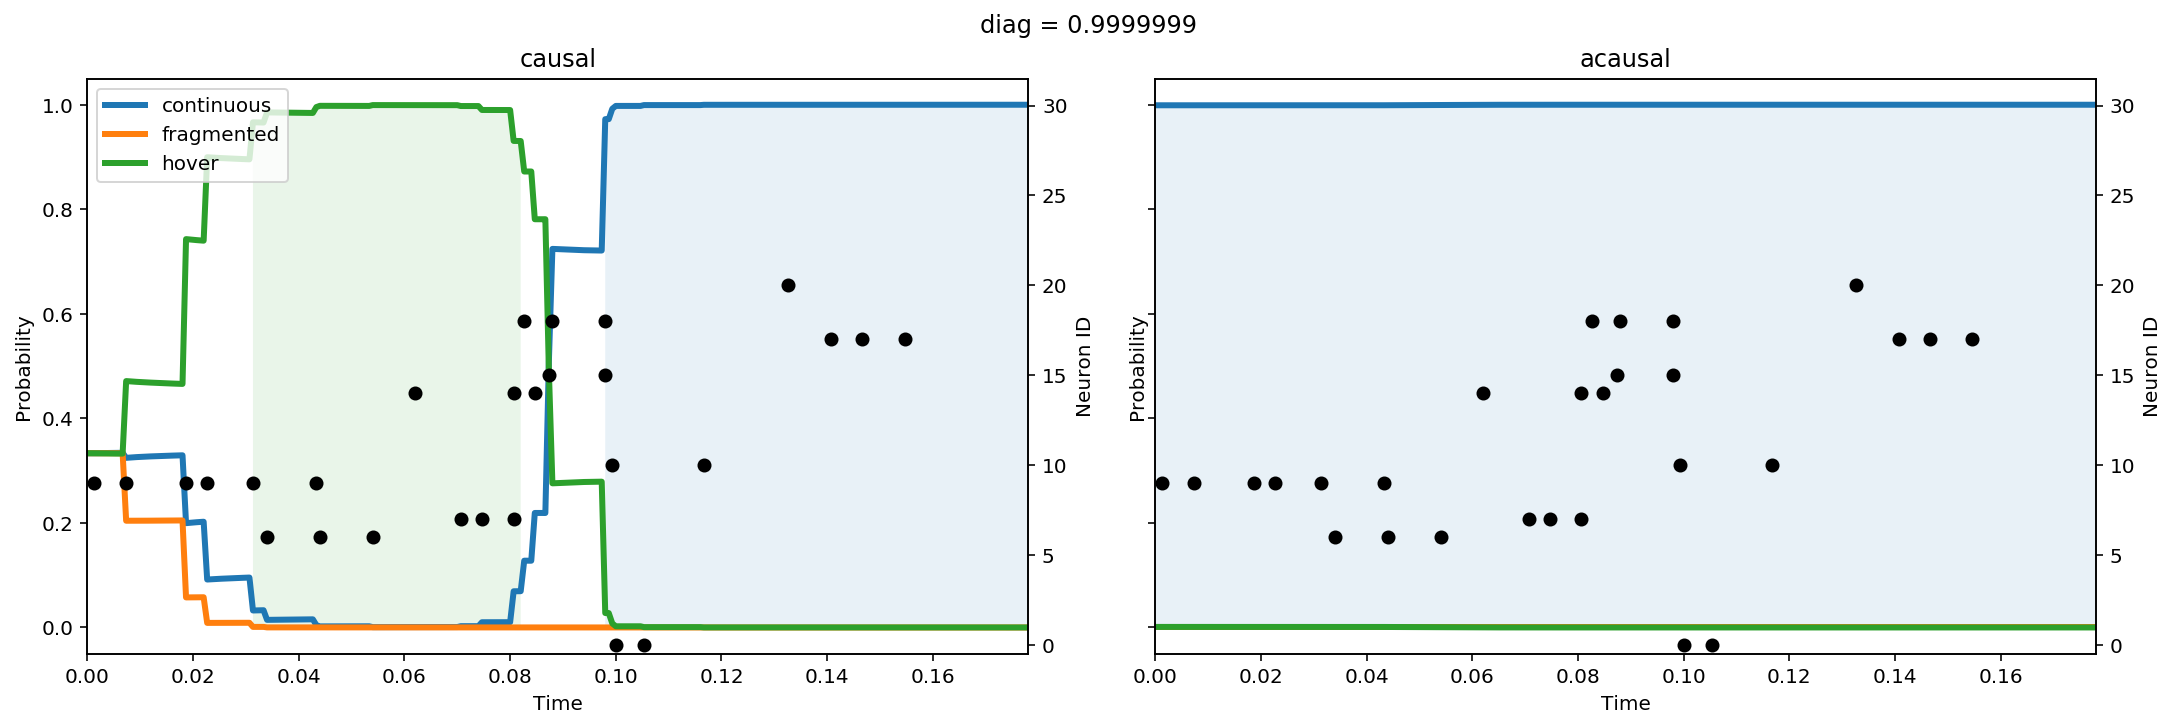

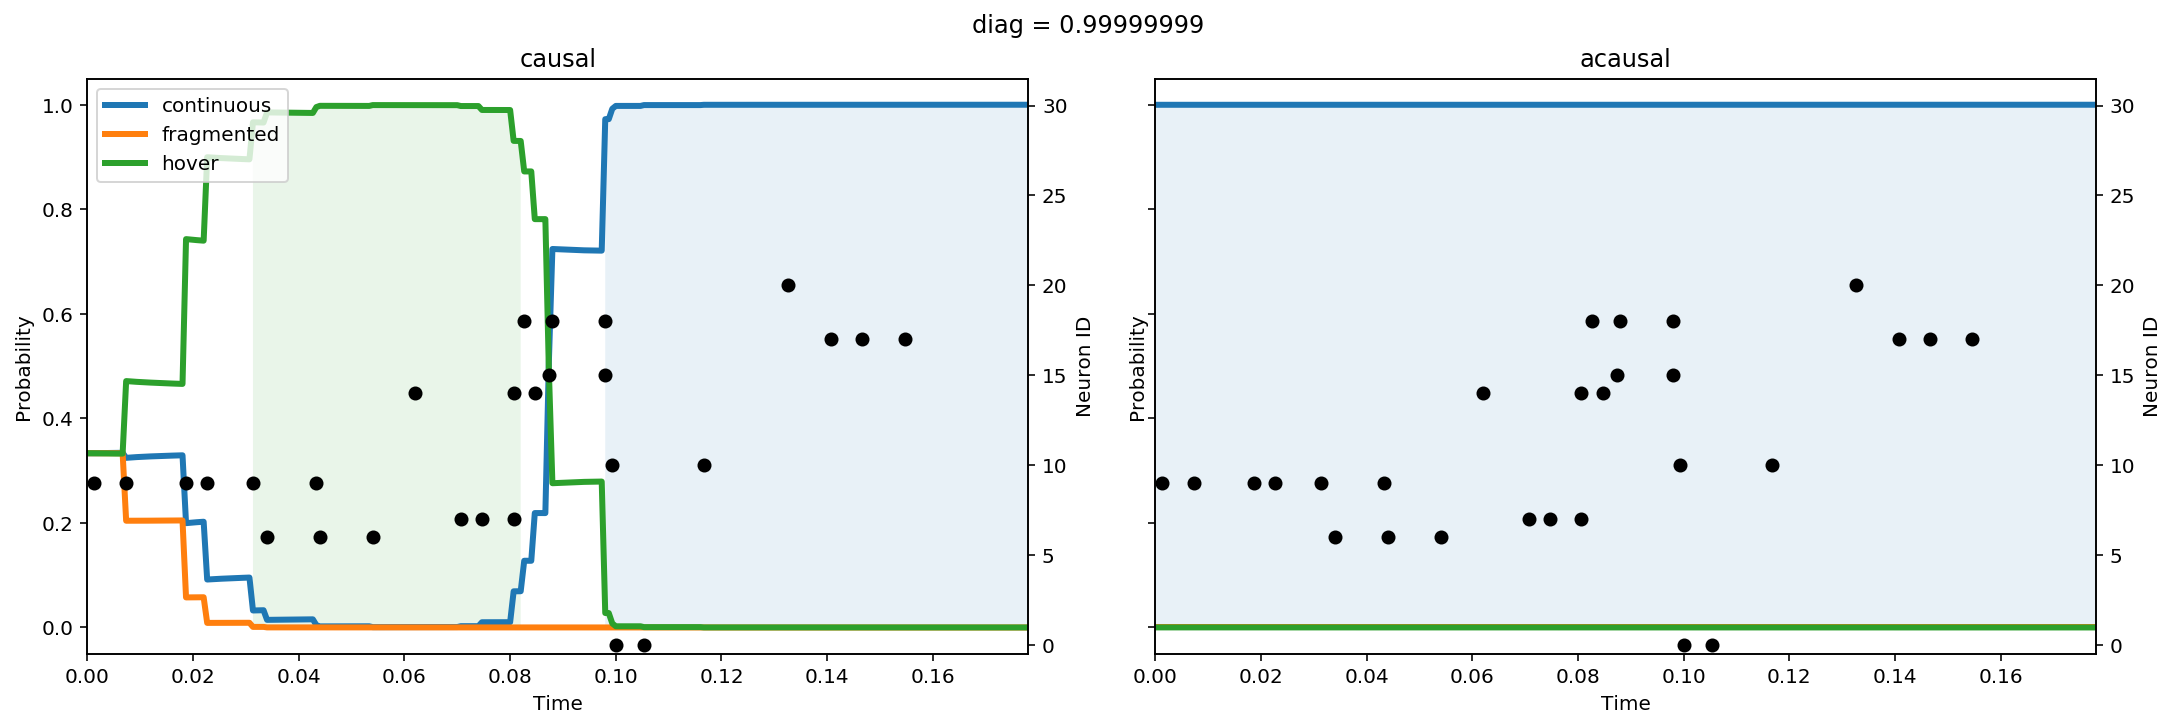

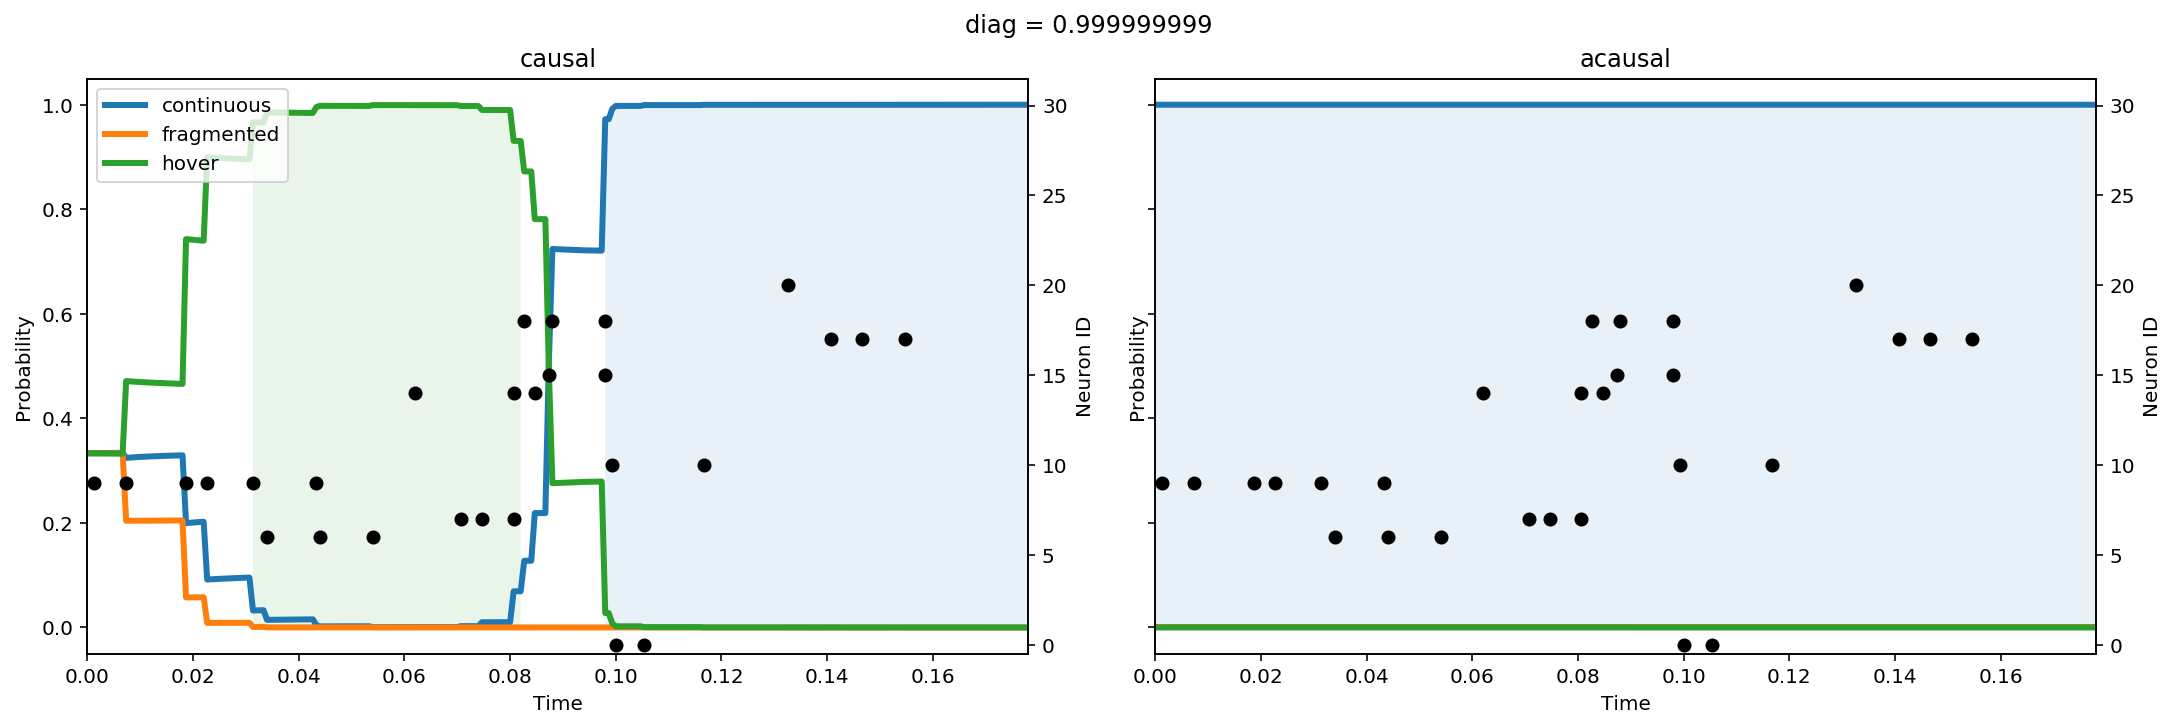

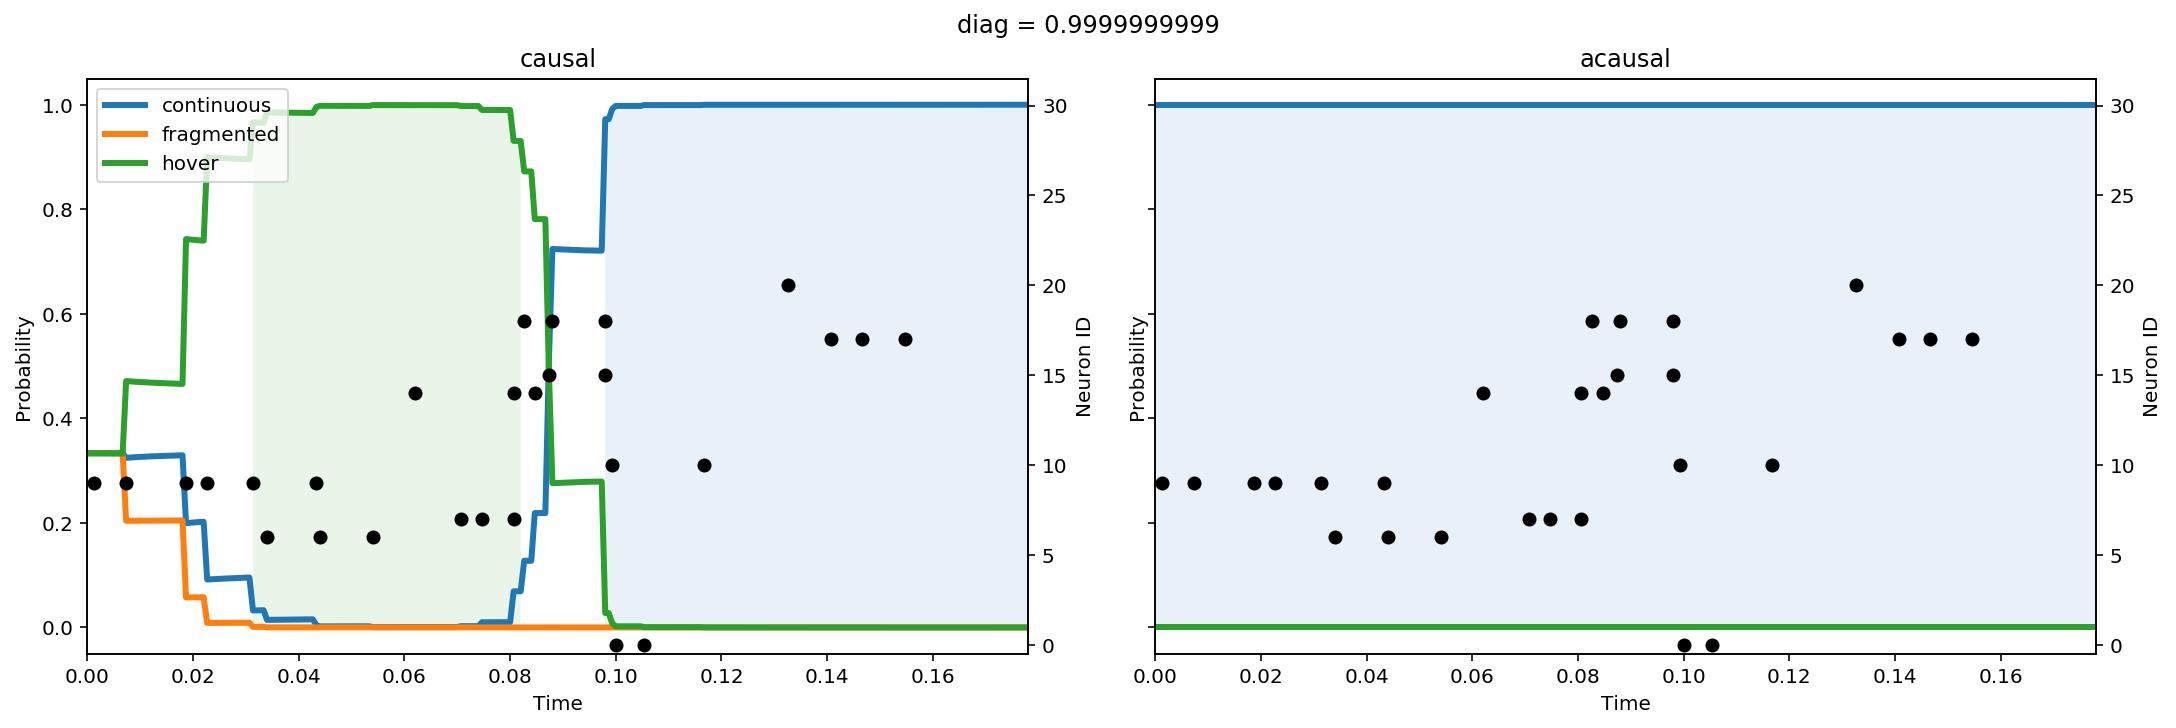

In [211]:
from copy import deepcopy

def plot_classifier_probabilities(results, spikes, time, classifier):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5),
                             sharex=True, sharey=True,
                             constrained_layout=True)
    transition_to_category = [
        ('random_walk_with_absorbing_boundaries', 'continuous'),
        ('uniform', 'fragmented'),
        ('identity', 'hover')]

    probabilities = classifier.predict_proba(results)
    posterior_names = ['causal_posterior', 'acausal_posterior']
    spike_time_ind, neuron_ind = np.nonzero(spikes)
    n_neurons = spikes.shape[1]
    
    for ax, posterior_name in zip(axes.flat, posterior_names):
        for state, category in transition_to_category:
            p = probabilities[posterior_name].sel(state=state).values
            ax.plot(probabilities.time, p, label=category, linewidth=3, zorder=1)
            ax.fill_between(probabilities.time, p, alpha=0.1, where=p>0.9, zorder=-100)
        ax.set_xlim((time.min(), time.max()))
        ax.set_ylim((-0.05, 1.05))
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_title(posterior_name.split('_')[0])
        
        twin_ax = ax.twinx()
        twin_ax.scatter(time[spike_time_ind], neuron_ind, color='black', zorder=100)
        twin_ax.set_ylim((-0.5, n_neurons - 0.5))
        twin_ax.set_ylabel('Neuron ID')
    axes[0].legend(loc='upper left')

c = deepcopy(classifier)
ripple_number = 284
diags = 1 - (10.0**(-np.arange(1, 11)))

for ind, diag in enumerate(tqdm(diags)):
    c.fit_discrete_state_transition(diag)
    result = c.predict(ripple_spikes.loc[ripple_number],
                       time=ripple_spikes.loc[ripple_number].index.total_seconds().values)
    plot_classifier_probabilities(result, ripple_spikes.loc[ripple_number].values, result.time, c)
    plt.suptitle(f'diag = {diag}')
    plt.savefig(f'classifier_{ind + 1:02d}.png', bbox_inches='tight')

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'bon_03_02_284.mp4']


(<Figure size 504x504 with 2 Axes>,
 <matplotlib.animation.FuncAnimation at 0x1e61131630>)

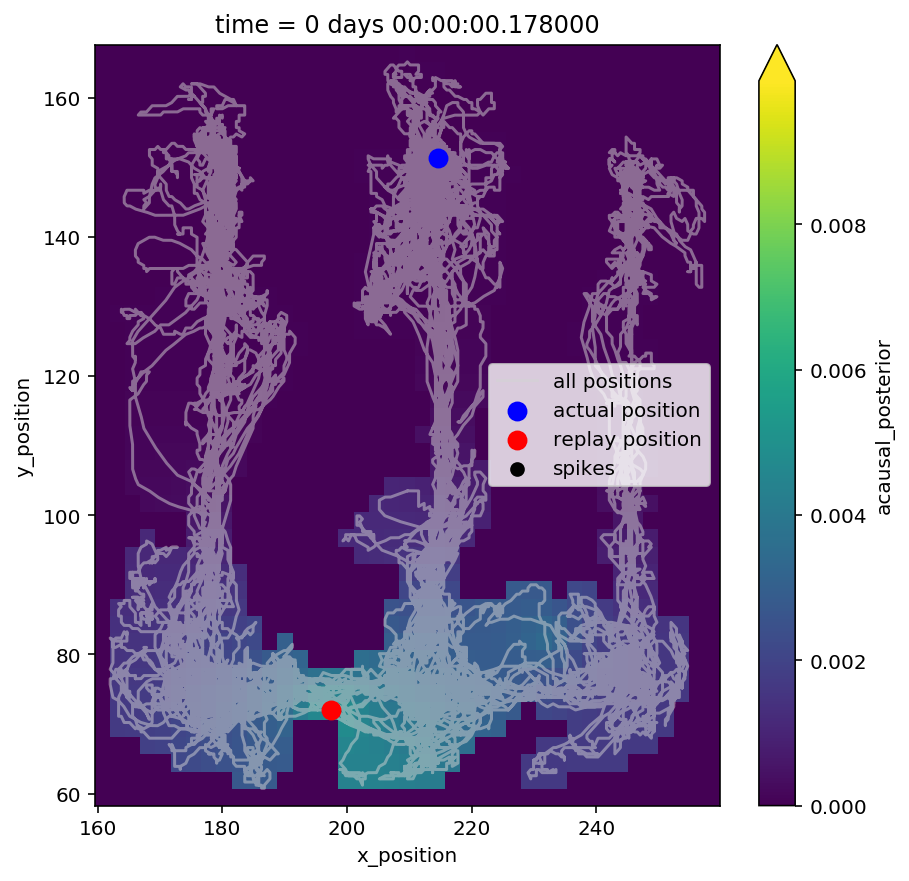

In [231]:
from replay_trajectory_classification.visualization import make_movie

ripple_number = 284
result = results[ripple_number - 1]

posterior_density = (result.acausal_posterior.sum('state')
                     .assign_coords(time=lambda da: da.time / np.timedelta64(1, 's')))
position_info = data['position_info']
position = ripple_position.loc[ripple_number].values
map_position = maximum_a_posteriori_estimate(posterior_density)
spikes = ripple_spikes.loc[ripple_number].values
animal, day, epoch = epoch_key

make_movie(position, posterior_density, position_info, map_position,
               spikes, place_field_max,
           movie_name=f'{animal}_{day:02d}_{epoch:02d}_{ripple_number:03d}.mp4')

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'bon_03_02_187.mp4']


(<Figure size 504x504 with 2 Axes>,
 <matplotlib.animation.FuncAnimation at 0x1ee3711fd0>)

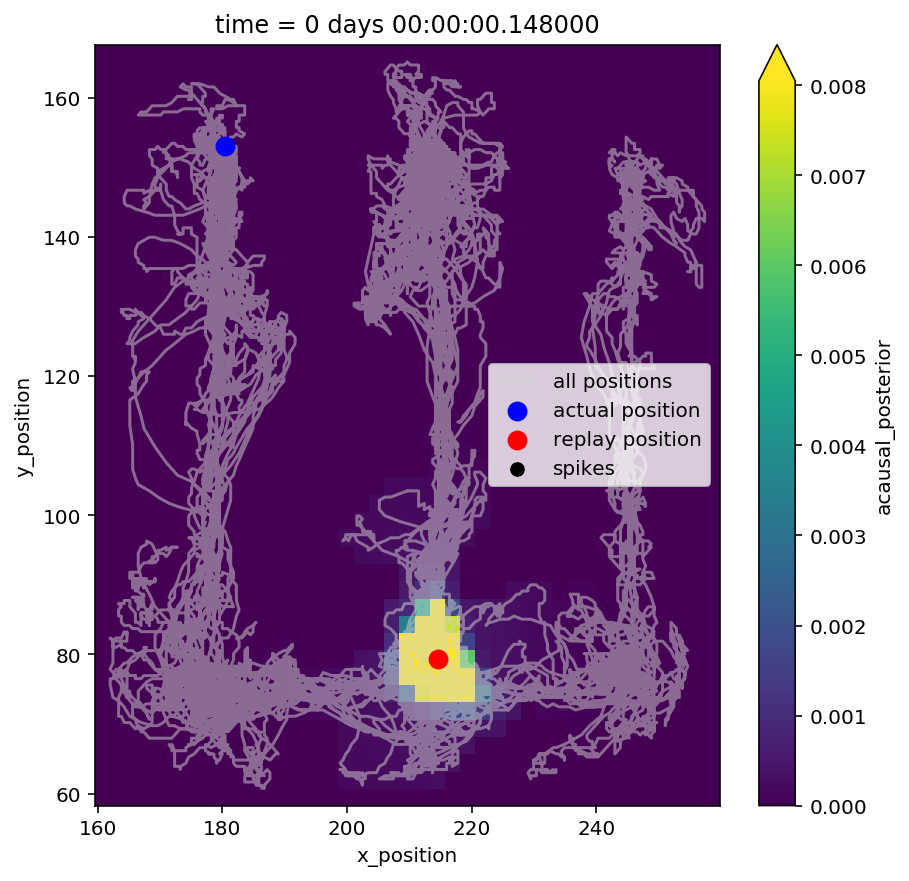

In [232]:
ripple_number = 187
result = results[ripple_number - 1]

posterior_density = (result.acausal_posterior.sum('state')
                     .assign_coords(time=lambda da: da.time / np.timedelta64(1, 's')))
position_info = data['position_info']
position = ripple_position.loc[ripple_number].values
map_position = maximum_a_posteriori_estimate(posterior_density)
spikes = ripple_spikes.loc[ripple_number].values
animal, day, epoch = epoch_key

make_movie(position, posterior_density, position_info, map_position,
               spikes, place_field_max,
           movie_name=f'{animal}_{day:02d}_{epoch:02d}_{ripple_number:03d}.mp4')

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'bon_03_02_214.mp4']


(<Figure size 504x504 with 2 Axes>,
 <matplotlib.animation.FuncAnimation at 0x1ef5a86710>)

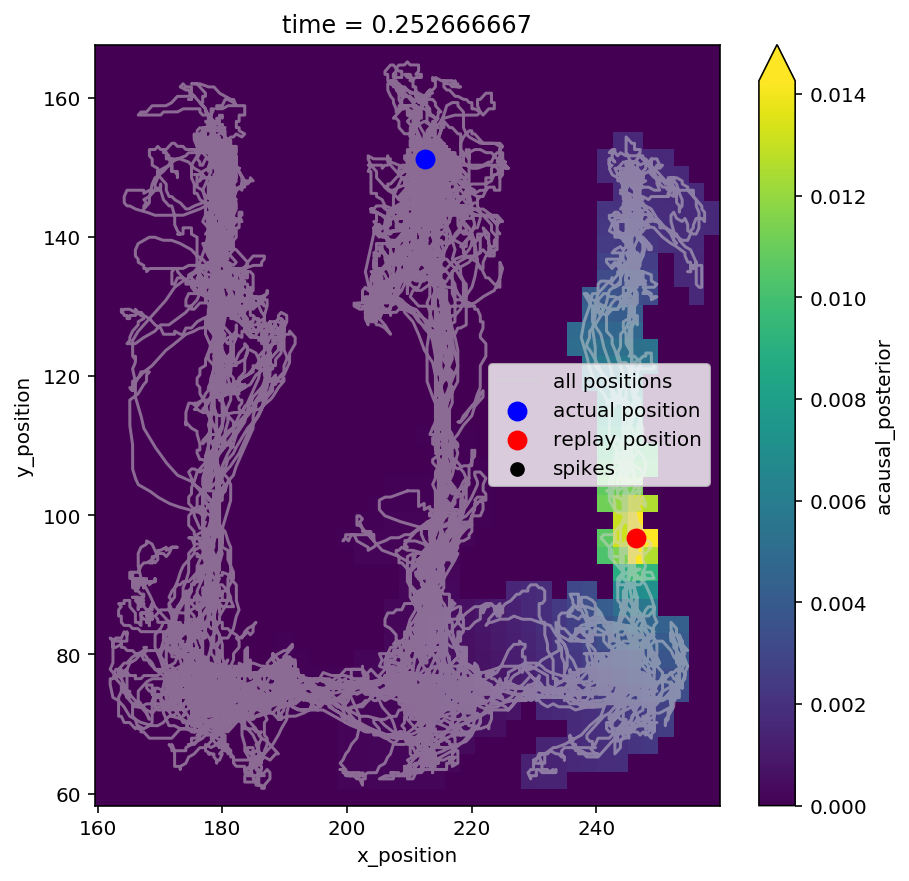

In [233]:
ripple_number = 214
result = results[ripple_number - 1]

posterior_density = (result.acausal_posterior.sum('state')
                     .assign_coords(time=lambda da: da.time / np.timedelta64(1, 's')))
position_info = data['position_info']
position = ripple_position.loc[ripple_number].values
map_position = maximum_a_posteriori_estimate(posterior_density)
spikes = ripple_spikes.loc[ripple_number].values
animal, day, epoch = epoch_key

make_movie(position, posterior_density, position_info, map_position,
               spikes, place_field_max,
           movie_name=f'{animal}_{day:02d}_{epoch:02d}_{ripple_number:03d}.mp4')

In [431]:
from replay_trajectory_classification.state_transition import empirical_movement

empirical_state_transition = empirical_movement(
    data['position_info'].loc[:, ['x_position', 'y_position']].values,
    classifier.edges_,
    is_training=is_training.values,
    replay_speed=1)

In [247]:
position = data['position_info'].loc[:, ['x_position', 'y_position']].resample('10ms').mean().fillna(method='pad').values
is_training = (data['position_info'].linear_speed).resample('10ms').mean().fillna(method='pad').values > 4
np.diag(np.cov(np.diff(position, axis=0)[is_training[1:]], rowvar=False)).max()

0.04545378172577065

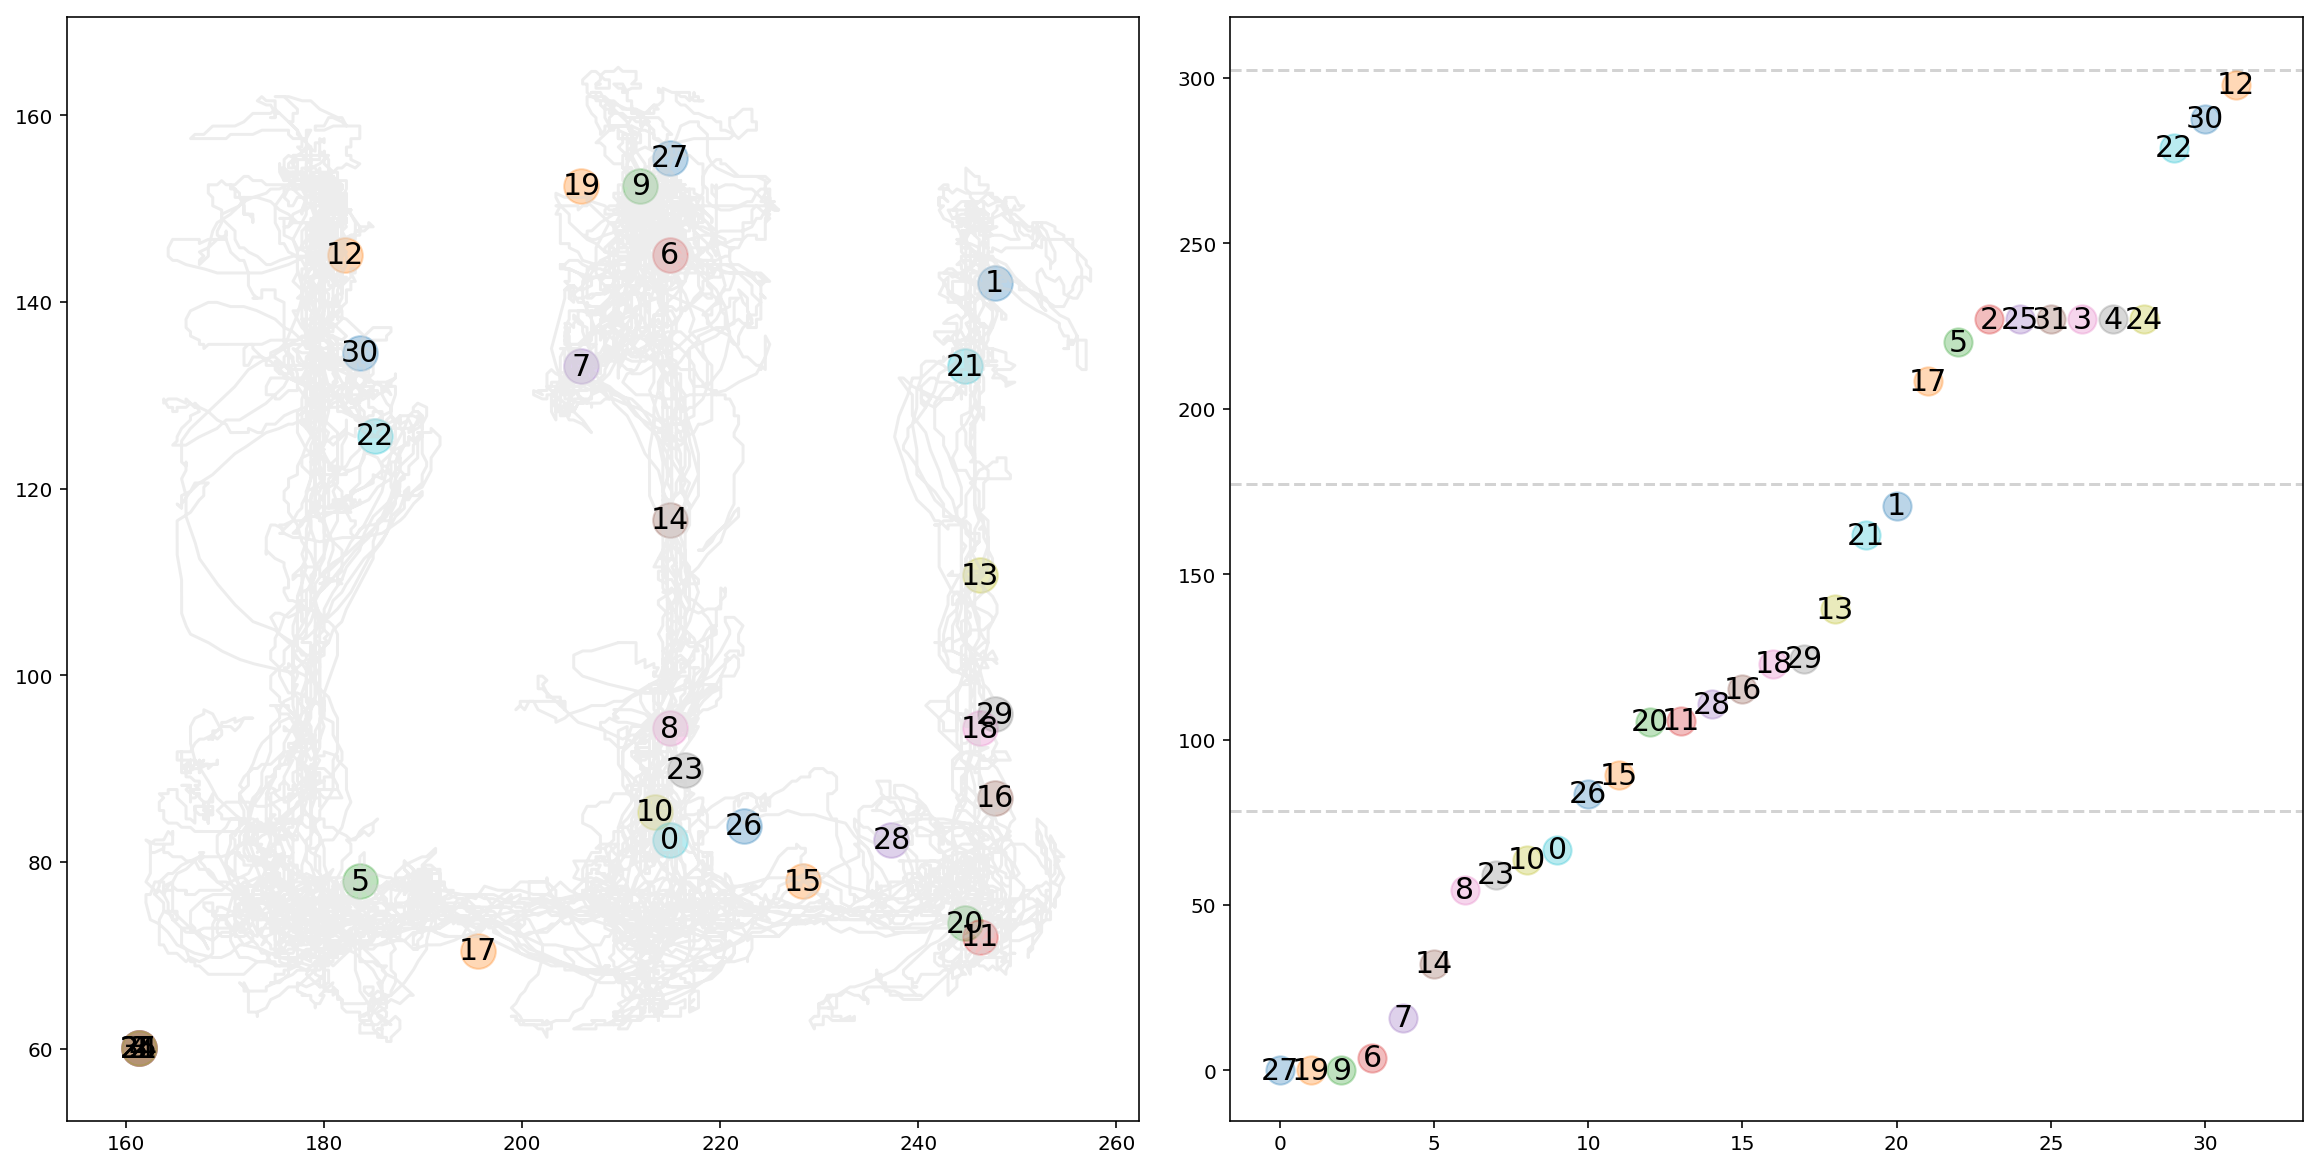

In [1004]:
# Need plot that shows spikes in aranged by linearized position
position = data['position_info'].loc[:, ['x_position', 'y_position']]
linear_place_field_max = []

for place_max in place_field_max:
    min_ind = np.sqrt(np.sum(np.abs(place_max - position) ** 2, axis=1)).argmin()
    linear_place_field_max.append(data['position_info'].loc[min_ind, 'linear_position2'])
    
linear_place_field_max = np.asarray(linear_place_field_max)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
axes[0].plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4)

sort_order = np.argsort(linear_place_field_max)

for ind, (linear, place_max) in enumerate(zip(linear_place_field_max[sort_order], place_field_max[sort_order])):
    axes[0].scatter(place_max[0], place_max[1], s=300, alpha=0.3)
    axes[0].text(place_max[0], place_max[1], sort_order[ind], fontsize=15, horizontalalignment='center',
                 verticalalignment='center')
    axes[1].scatter(ind, linear, s=200, alpha=0.3)
    axes[1].text(ind, linear, sort_order[ind], fontsize=15,  horizontalalignment='center',
                 verticalalignment='center')
    
for track_id_max in data['position_info'].groupby('arm_name').linear_position2.max().values:
    axes[1].axhline(track_id_max, color='lightgrey', zorder=0, linestyle='--')

In [1083]:
from ipywidgets import interact
from replay_trajectory_classification.visualization import plot_2D_position_with_color_time

n_classified = is_classified.sum()
n_ripples = len(results)

@interact(ripple_ind=(0, n_ripples-1))
def _plot_posterior(ripple_ind=0):
    state_map = {'identity': 'hover', 'uniform': 'fragmented', 'random_walk_with_absorbing_boundaries': 'continuous'}
    result = results[ripple_ind].assign_coords(
        time=lambda ds: ds.time / np.timedelta64(1, 's'),
        state=lambda ds: ds.state.to_index().map(state_map)
    )
    time = result.time.values
    ripple_number = data['ripple_times'].loc[data['ripple_times'].n_unique_spiking > 4].index[ripple_ind]
    map_estimate = maximum_a_posteriori_estimate(result.acausal_posterior.sum('state'))
    spike_time_ind, neuron_ind = np.nonzero(ripple_spikes.loc[ripple_number].values[:, sort_order])
    n_neurons = ripple_spikes.shape[1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    g = classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[0], linewidth=3);
    axes[0].set_ylim((0, 1))

    twin_ax = axes[0].twinx()
    twin_ax.scatter(time[spike_time_ind], neuron_ind, color='black', zorder=1, marker="|",
                    s=80, linewidth=2)
    twin_ax.set_ylim((-0.5, n_neurons - 0.5))
    twin_ax.set_ylabel('Neuron ID')
    
    box =  axes[0].get_position()
    axes[0].set_position([box.x0, box.y0 + box.height * 0.1,
                          box.width, box.height * 0.9])

    # Put a legend below current axis
    axes[0].legend(g, result.state.values, loc='upper right', bbox_to_anchor=(1.0, -0.05),
                   fancybox=False, shadow=False, ncol=1, frameon=False)


    axes[1].plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=0)
    plot_2D_position_with_color_time(
        time, map_estimate, ax=axes[1])
    axes[1].scatter(ripple_position.loc[ripple_number].values[:, 0],
               ripple_position.loc [ripple_number].values[:, 1], color='black',
               s=100, label='actual position');
    result.sum(['state', 'time']).acausal_posterior.plot(
        x='x_position', y='y_position', robust=True, cmap='Purples', alpha=0.3, ax=axes[1],
        add_colorbar=False, zorder=0)

    axes[1].legend()


interactive(children=(IntSlider(value=0, description='ripple_ind', max=113), Output()), _dom_classes=('widget-…